# Metabolon Analysis



## imports

In [1]:
from Analyses.KEGGDataBuilder import *
from scipy.stats.stats import mannwhitneyu, spearmanr, pearsonr
from scipy.stats import shapiro
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mne.stats.multi_comp import fdr_correction
import pickle
import numpy as np
import pandas as pd
from stats.HigherLevelRanksum import directed_mannwhitneyu
from pandas import concat, to_pickle, read_csv, Series
from Analyses.grouping import semi_exahustive_strict_cor_grouping, strict_cor_grouping, newalg
from addloglevels import sethandlers
from queue.qp import qp
import os
from scipy.spatial.distance import braycurtis, pdist, squareform, euclidean, cdist
from Analyses.MantelTest import test as mantel_test
import re
from load_data import get_pnp_ids, get_preprocessed
import inspect
import random
import urllib2
from collections import Counter
from collections import defaultdict
from Bio import SeqIO

METABOLON_DIR = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/'

filepath = '/net/mraid08/export/jafar/Microbiome/Data/InHouseSeqData/PNP/Metabolon/WEIZ-01-16ML+ CDT 31MAR2017.XLSX'
manifest = '/net/mraid08/export/jafar/Microbiome/Data/InHouseSeqData/PNP/Metabolon/Sample manifest_WEIZ-01-16ML+ (1).xlsx'

## functions

In [2]:
def print_plus(i):
    print str(datetime.now()) + str(i[0])
    i[0] += 1

def clip_min_max(df):
    return df.clip(lower = df.quantile(2./df.shape[0]), upper = df.quantile(float(df.shape[0]-1)/df.shape[0]), axis = 1).copy()

def count_spread(arr, resolution=0.5):
    return len(set([int(r/resolution) for r in arr[~np.isnan(arr)]]))

def compute_moving_average(x, window_size=100, method=np.median):
    if window_size >= len(x):
        return [method(x)] * len(x)
    conv_vals = []
    for i in range(len(x)):
        conv_vals += [method(x[max(0,i-window_size/2):i+window_size/2])]
    return np.array(conv_vals)

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def BrayCurtis(X):
    return braycurtis(X[0,:], X[1:,])

def compute_distance_matrix(samps_by_features, distance_meausere, do_binary = False):
    A = samps_by_features.T.copy()
    temp_res = pd.DataFrame(1, index=A.columns, columns=A.columns, dtype=np.float64)
    A = A.values
    if do_binary:
        A[A>0] = 1
    for i in range(A.shape[1]):
        a = A[:,i]
        vals = []
        if i % 10 == 0:
            print i
        for j in range(A.shape[1]):
            b = A[:,j]
            val = None
            val = distance_meausere(np.stack((a,b),axis=1).T)
            vals.append(val)
        temp_res.iloc[i,:] = vals
    return temp_res

def read_fasta_to_dict(path):
    return {rec.id : rec.seq.__str__() for rec in SeqIO.parse(path, "fasta")}

In [295]:
print datetime.now()
protein_fasta = read_fasta_to_dict('../KEGG_DB_12_12_2017/KEGG_genes_Bacteria_protein.fa')
print datetime.now()

2017-12-17 14:23:22.825012
2017-12-17 14:27:45.525818


In [118]:
ppmet, samps, metabs = get_preprocessed()

In [124]:
pnp_ids = get_pnp_ids()

2017-11-22 09:55:10,769 - tunneltoamazondb - INFO - Raising pexpect tunnel


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/wisdom/python/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/noamba/workspace/PNP/tunneltoamazondb.py", line 33, in _start_tunnel
    ssh_tunnel.expect(pexpect.EOF)
  File "/usr/wisdom/python/lib/python2.7/site-packages/pexpect/spawnbase.py", line 321, in expect
    timeout, searchwindowsize, async)
  File "/usr/wisdom/python/lib/python2.7/site-packages/pexpect/spawnbase.py", line 345, in expect_list
    return exp.expect_loop(timeout)
  File "/usr/wisdom/python/lib/python2.7/site-packages/pexpect/expect.py", line 107, in expect_loop
    return self.timeout(e)
  File "/usr/wisdom/python/lib/python2.7/site-packages/pexpect/expect.py", line 70, in timeout
    raise TIMEOUT(msg)
TIMEOUT: Timeout exceeded.
command: /bin/ssh
args: ['/bin/ssh', '-oStrict

## Process metabolon data

In [126]:
getanchor = lambda df: df.loc[df.index.get_level_values(1).str.startswith('Anchor'), df.columns.get_level_values(1).str.startswith('Anchor')]
getnonanchor = lambda df: df.loc[~df.index.get_level_values(1).str.startswith('Anchor'), ~df.columns.get_level_values(1).str.startswith('Anchor')].where(np.triu(np.ones((~df.index.get_level_values(1).str.startswith('Anchor')).sum()), k = 1).astype(bool))
getintrabatch = lambda df: df.where(np.array([df.index.get_level_values(0) == c for c in df.columns.get_level_values(0)]))
getinterbatch = lambda df: df.where(np.array([df.index.get_level_values(0) != c for c in df.columns.get_level_values(0)]))
getuptri = lambda df: df.where(np.triu(np.ones(df.shape[0]), k = 1).astype(bool))

In [128]:
met_spr = ppmet.T.corr('spearman')

In [1630]:
ppmet.shape

(540, 1251)

In [386]:
anchor_ppmet = ppmet.loc[ppmet.index.get_level_values(1).str.startswith('Anchor')]
nonanchor_ppmet = ppmet.loc[~ppmet.index.get_level_values(1).str.startswith('Anchor')]
anchor_ppmet_no_na_all = anchor_ppmet.loc[:,anchor_ppmet.notnull().sum() > 0].copy()
anchor_ppmet_num_of_na = [anchor_ppmet.loc[:,anchor_ppmet.notnull().sum() > i].copy() for i in range(anchor_ppmet.shape[0])]

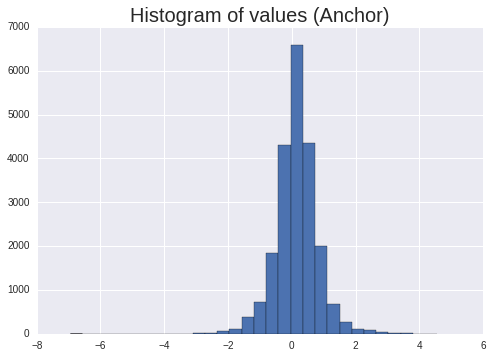

In [348]:
plt.hist(anchor_ppmet.stack().dropna(), bins=30)
plt.title('Histogram of values (Anchor)', fontsize=20)
plt.show()
min_val = -4
anchor_ppmet_no_na = anchor_ppmet.fillna(min_val)

### STD and mean

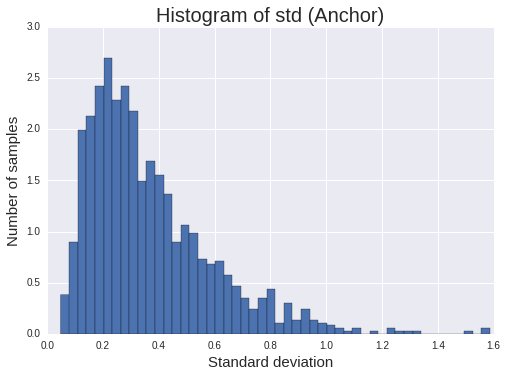

In [232]:
# histogram of std
plt.hist(anchor_ppmet.std().dropna(), bins=50, normed=True)
plt.title('Histogram of std (Anchor)', fontsize=20)
plt.xlabel('Standard deviation', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.savefig('fig/Hist_std_Anchor.png')
plt.show()

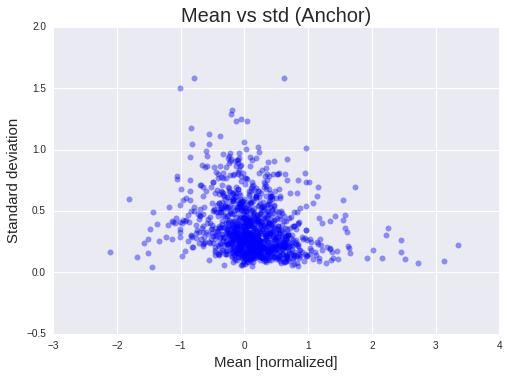

In [233]:
# mean vs std
plt.scatter(anchor_ppmet.mean(), anchor_ppmet.std(), alpha=0.4, s=30, color='blue')
plt.title('Mean vs std (Anchor)', fontsize=20)
plt.xlabel('Mean [normalized]', fontsize=15)
plt.ylabel('Standard deviation', fontsize=15)
plt.savefig('fig/Mean_vs_std_Anchor.png')
plt.show()

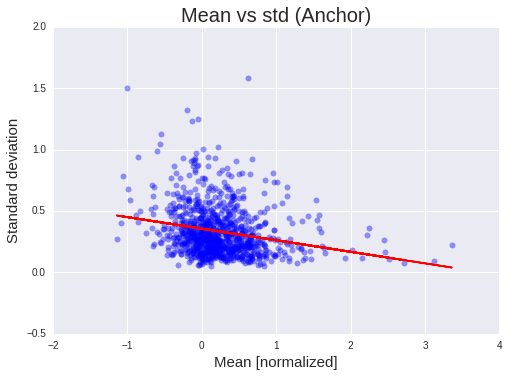

In [1187]:
# mean vs std all anchors
plt.scatter(anchor_ppmet_num_of_na[18].mean(), anchor_ppmet_num_of_na[18].std(), alpha=0.4, s=30, color='blue')
plt.title('Mean vs std (Anchor)', fontsize=20)
plt.xlabel('Mean [normalized]', fontsize=15)
plt.ylabel('Standard deviation', fontsize=15)
np.polyfit(anchor_ppmet_num_of_na[18].mean(), anchor_ppmet_num_of_na[18].std(), 1)
slope, intercept = np.polyfit(anchor_ppmet_num_of_na[18].mean(), anchor_ppmet_num_of_na[18].std(), 1)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in anchor_ppmet_num_of_na[18].mean()]

# Plot the best fit line over the actual values
plt.plot(anchor_ppmet_num_of_na[18].mean(), abline_values, 'r')
plt.savefig('fig/Mean_vs_std_Anchor_all.png')
plt.show()

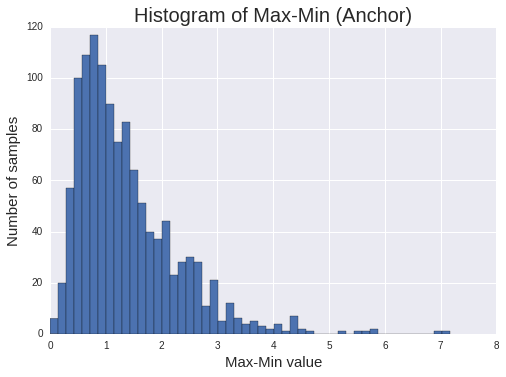

In [234]:
# histogram of max-min
plt.hist(anchor_ppmet.max().dropna()-anchor_ppmet.min().dropna(), bins=50)
plt.title('Histogram of Max-Min (Anchor)', fontsize=20)
plt.xlabel('Max-Min value', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.savefig('fig/Hist_Max-Min_Anchor.png')
plt.show()

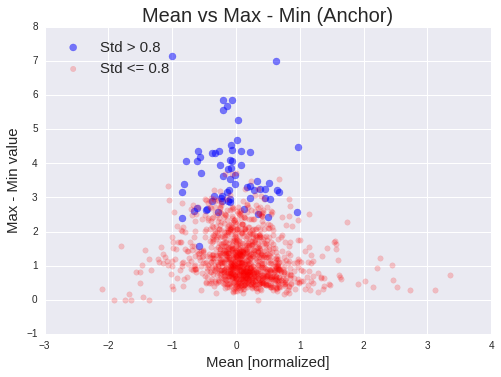

In [235]:
# Mean vs Max-Min
cc = (anchor_ppmet.std() > 0.8)
plt.scatter(anchor_ppmet.mean().loc[cc], anchor_ppmet.max().loc[cc]-anchor_ppmet.min().loc[cc], color='blue',  s=50, alpha=0.5, label='Std > 0.8')
plt.scatter(anchor_ppmet.mean().loc[~cc], anchor_ppmet.max().loc[~cc]-anchor_ppmet.min().loc[~cc], color='red', s=30, alpha=0.2, label='Std <= 0.8')
plt.title('Mean vs Max - Min (Anchor)', fontsize=20)
plt.xlabel('Mean [normalized]', fontsize=15)
plt.ylabel('Max - Min value', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.savefig('fig/Mean_vs_Max-Min_Anchor.png')
plt.show()

### clip max and min values

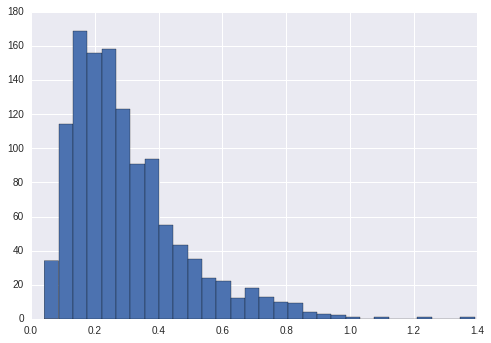

In [346]:
anchor_ppmet_no_na_all_min_max_clipped = clip_min_max(anchor_ppmet_no_na_all)
plt.hist(anchor_ppmet_no_na_all_min_max_clipped.std().dropna(), bins=30)
plt.show()

### missing values

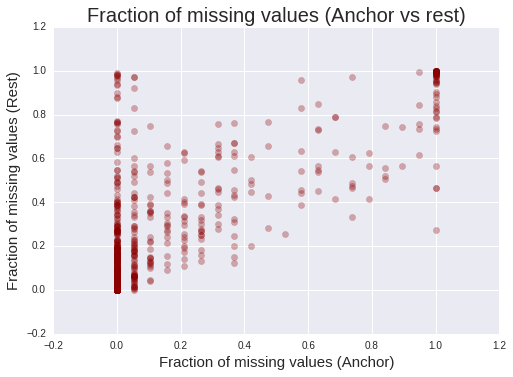

In [237]:
# fraction of missing values - anchor vs rest
frac_anchor_nulls = anchor_ppmet.isnull().sum() / float(anchor_ppmet.shape[0])
frac_nonanchor_nulls = nonanchor_ppmet.isnull().sum() / float(nonanchor_ppmet.shape[0])
plt.scatter(frac_anchor_nulls, frac_nonanchor_nulls, alpha=0.3, s=40, color='darkred')
plt.title('Fraction of missing values (Anchor vs rest)', fontsize=20)
plt.xlabel('Fraction of missing values (Anchor)', fontsize=15)
plt.ylabel('Fraction of missing values (Rest)', fontsize=15)
plt.savefig('fig/Fraction_of_missing_values_Anchor_vs_rest.png')
plt.show()

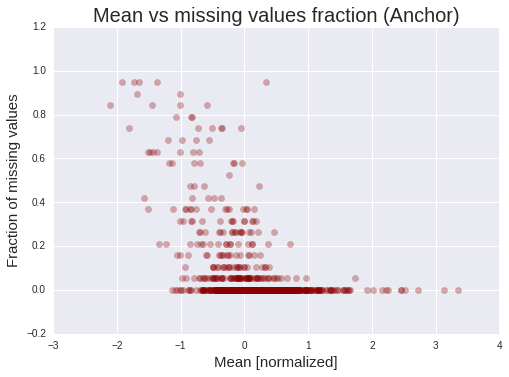

In [238]:
# fraction of missing values vs mean anchor
plt.scatter(anchor_ppmet.mean(), anchor_ppmet.isnull().sum()/float(anchor_ppmet.shape[0]), s=40, alpha=0.3, color='darkred')
plt.title('Mean vs missing values fraction (Anchor)', fontsize=20)
plt.xlabel('Mean [normalized]', fontsize=15)
plt.ylabel('Fraction of missing values', fontsize=15)
plt.savefig('fig/Fraction_of_missing_values_vs_mean_Anchor.png')
plt.show()

### detecting problematic batches

0.364760998388
0.367340681289
0.367340681289
0.367340681289
0.367340681289
0.369386671487
0.367924591207
0.365067780973
0.36205682109
0.36798429887
0.367202672208
0.368937950889
0.362278657169
0.368739127203
0.361055311678


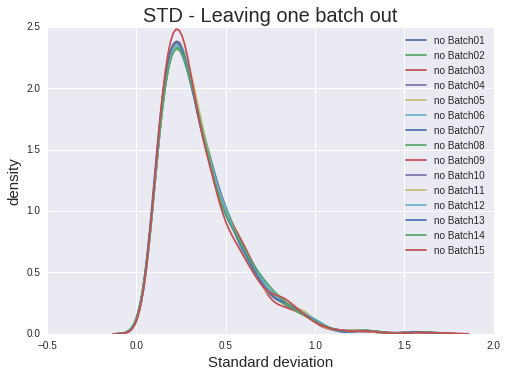

In [312]:
# density of std when leaving one batch out
for batch in anchor_ppmet.index.get_level_values(0).unique():
    batches = list(anchor_ppmet.index.get_level_values(0))
    batches.remove(batch)
    sns.distplot(anchor_ppmet.loc[batches].std().dropna(), hist=False, label='no ' + str(batch))
    plt.xlabel('Standard deviation', fontsize=15)
    plt.ylabel('density', fontsize=15)
    plt.title('STD - Leaving one batch out', fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    print anchor_ppmet.loc[batches].std().dropna().mean()

plt.savefig('fig/Std_distributin_leave_one_batch_out.png')
plt.show()

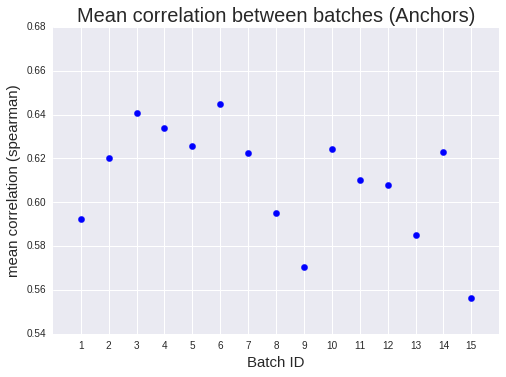

In [385]:
# compute mean correlation between anchors
mn_corr_batch = [getanchor(met_spr).loc[b].values.ravel().mean() for b in getanchor(met_spr).index.get_level_values(0).unique()]
plt.scatter(range(1,len(mn_corr_batch)+1), mn_corr_batch, s=40, color='blue')
plt.title('Mean correlation between batches (Anchors)', fontsize=20)
plt.xlabel('Batch ID', fontsize=15)
plt.ylabel('mean correlation (spearman)', fontsize=15)
plt.xticks(range(1,len(mn_corr_batch)+1))
plt.savefig('fig/mean_corr_between_anchors.png')
plt.show()

### reliability score

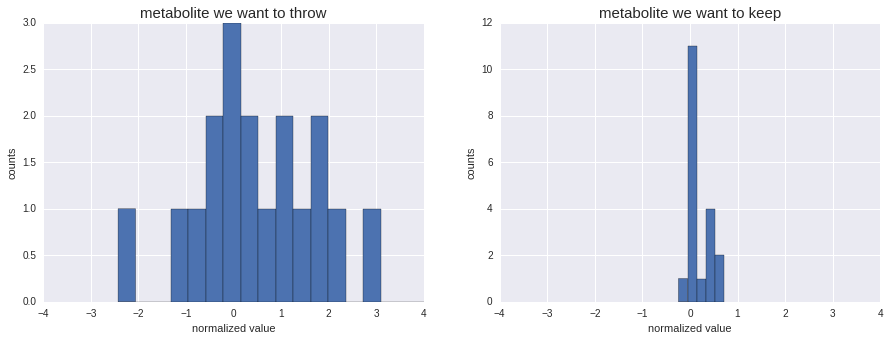

In [1113]:
# what we want to keep and what to throw
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlim((-4,4))
plt.hist(anchor_ppmet.loc[:,48080].dropna(), bins=19)
plt.title('metabolite we want to throw', fontsize=15)
plt.xlabel('normalized value')
plt.ylabel('counts')
plt.subplot(1,2,2)
plt.xlim((-4,4))
plt.hist(anchor_ppmet.iloc[:,6].dropna(), bins=5)
plt.title('metabolite we want to keep', fontsize=15)
plt.xlabel('normalized value')
plt.ylabel('counts')
plt.show()

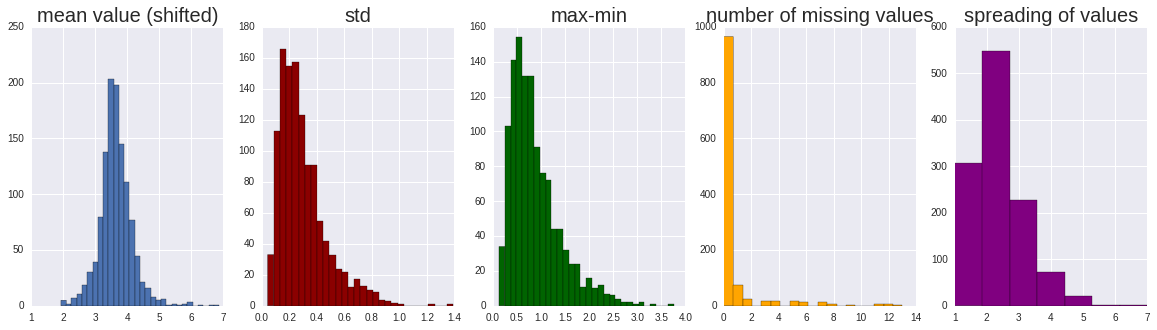

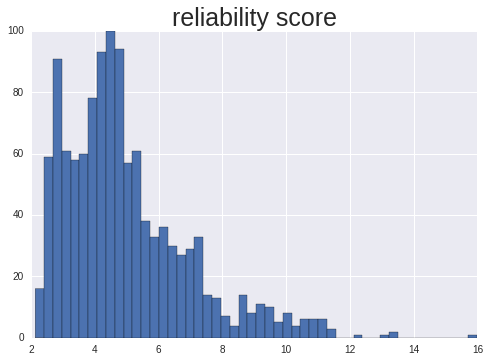

66
1112


In [1035]:
reliables = set(anchor_ppmet_num_of_na[15].columns[(anchor_ppmet_num_of_na[15].std() < 0.4) | (anchor_ppmet_num_of_na[15].mean() < -0.5)])
# rest = list(set(anchor_ppmet_num_of_na[5].columns).difference(reliables))
# temp_anchor = clip_min_max(anchor_ppmet_num_of_na[5].loc[:,rest].dropna(how='all', axis=1))
temp_anchor = clip_min_max(anchor_ppmet_num_of_na[5].dropna(how='all', axis=1))

plt.figure(figsize=(20,5))
# mean + min
plt.subplot(1,5,1)
mean_p_min = temp_anchor.mean() + min_val*(-1) - 0.5
plt.hist(mean_p_min, bins=30)
plt.title('mean value (shifted)', fontsize=20)

# std
plt.subplot(1,5,2)
std = temp_anchor.std()
plt.hist(std, bins=30, color='darkred')
plt.title('std', fontsize=20)

# max-min
plt.subplot(1,5,3)
mx_mn = temp_anchor.max()-temp_anchor.min()
plt.title('max-min', fontsize=20)
plt.hist(mx_mn, bins=30, color='darkgreen')

# num of na
plt.subplot(1,5,4)
nas = (temp_anchor.isnull().sum()+19)/19
plt.hist(temp_anchor.isnull().sum(), bins=19, color='orange')
plt.title('number of missing values', fontsize=20)

# spread
plt.subplot(1,5,5)
spread = temp_anchor.apply(count_spread)
plt.hist(spread, bins=max(spread), color='purple')
plt.title('spreading of values', fontsize=20)
plt.show()

plt.clf()

rel_score = mean_p_min/4 + std*5+mx_mn/2+spread
plt.hist(rel_score, bins=50)
plt.title('reliability score', fontsize=25)
plt.show()

rel_thresold = 9
unreliable = list(rel_score[(rel_score > rel_thresold)].index)
reliables = reliables.difference(set(unreliable))
reliables.update(rel_score[(rel_score <= rel_thresold)].index)
print len(unreliable)
print len(reliables)
plt.clf()

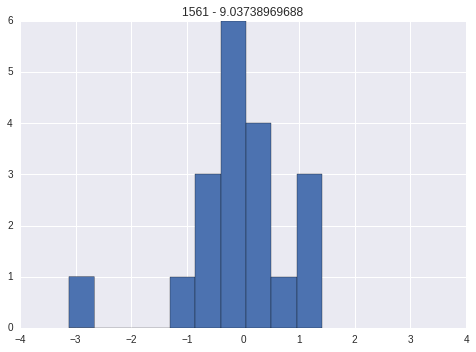

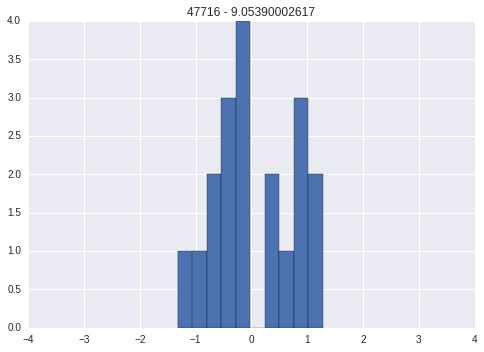

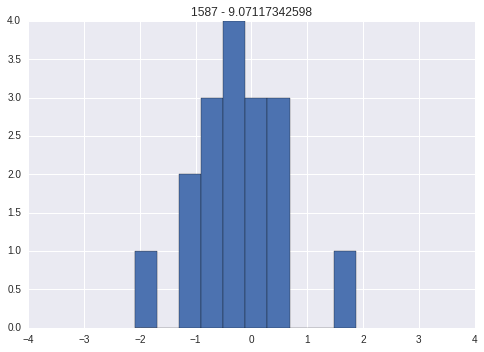

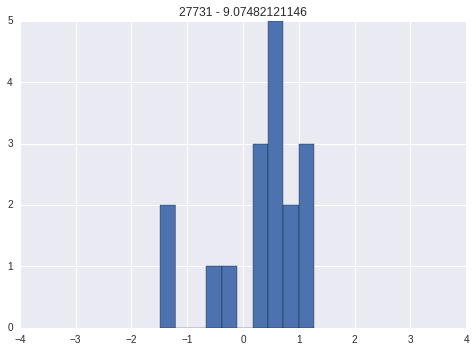

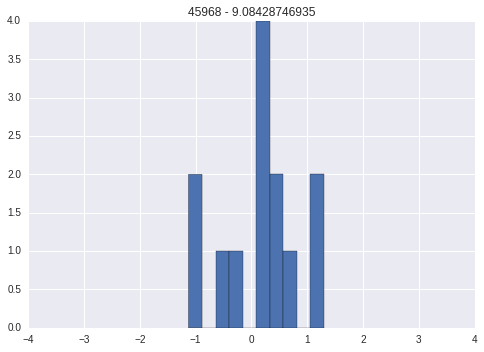

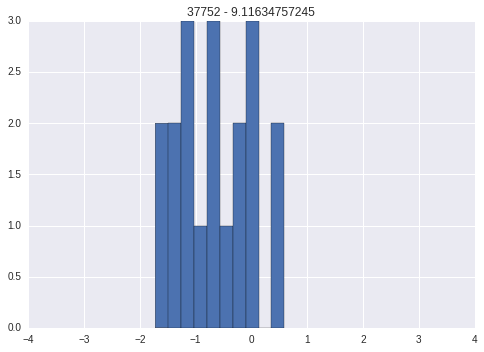

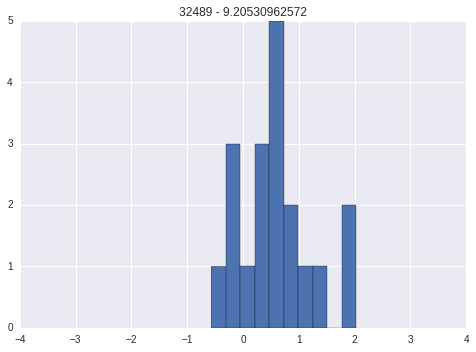

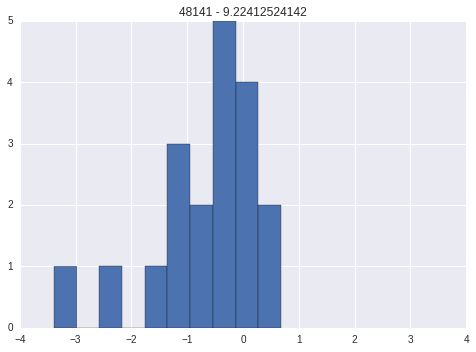

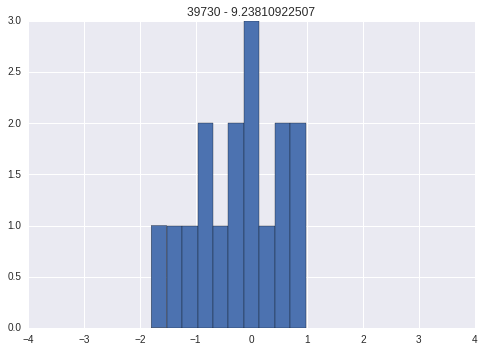

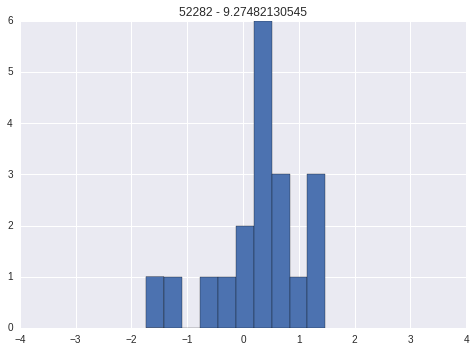

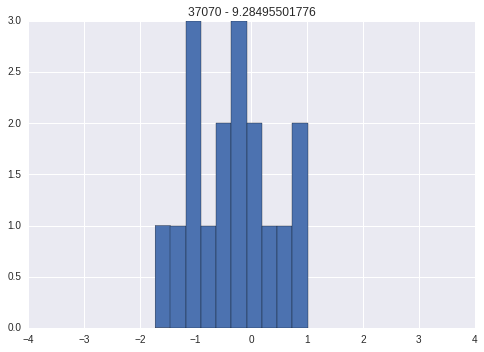

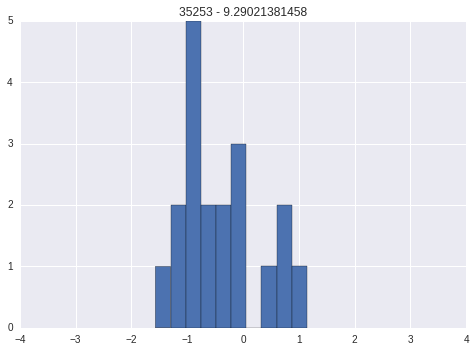

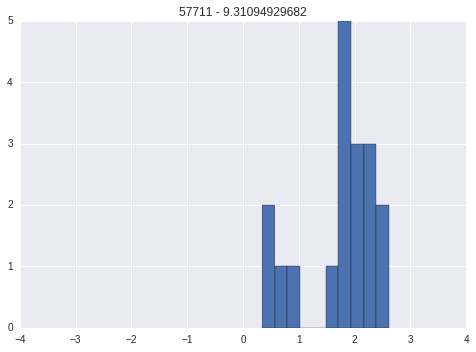

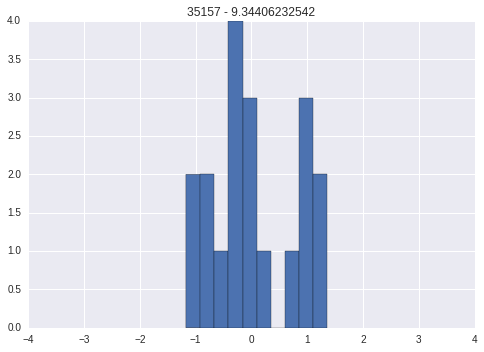

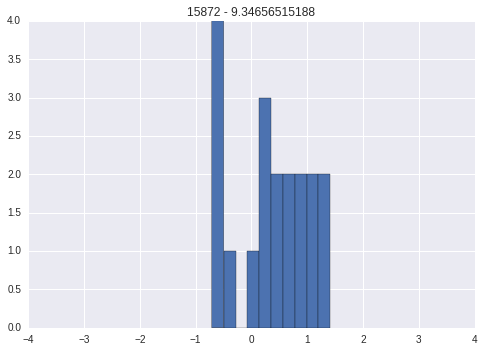

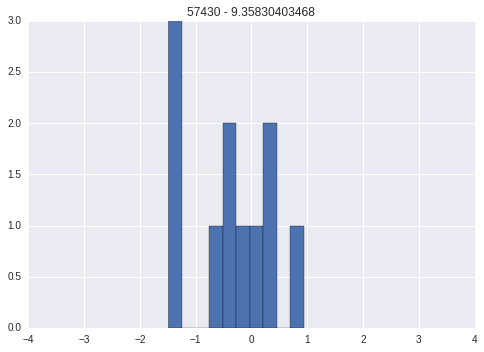

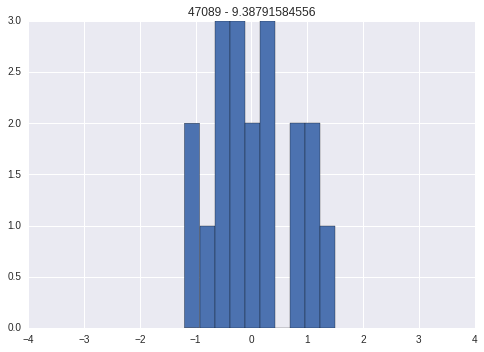

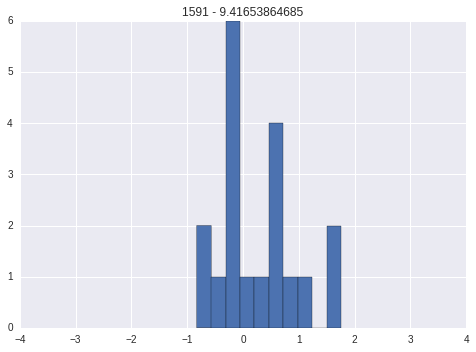

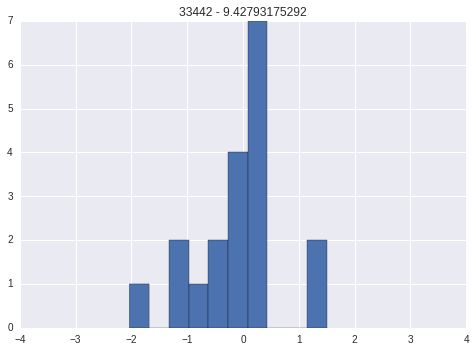

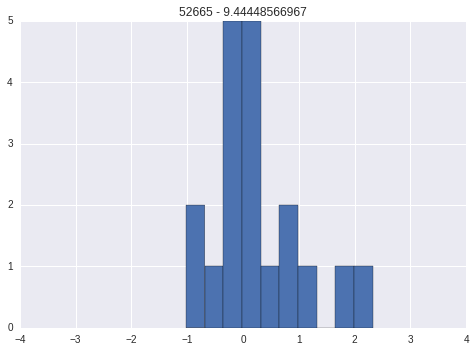

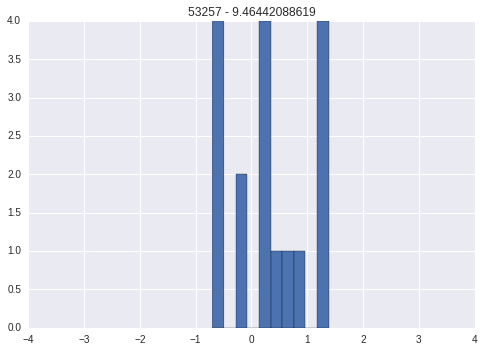

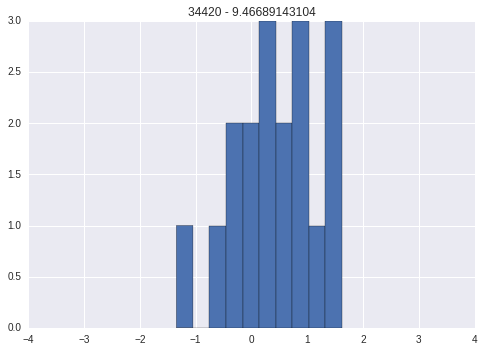

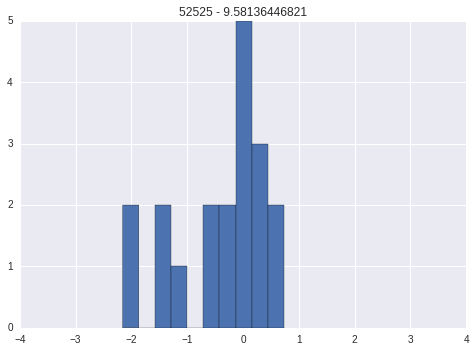

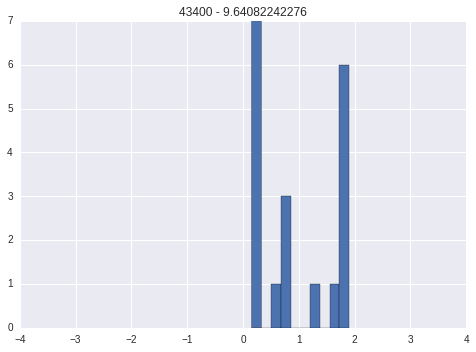

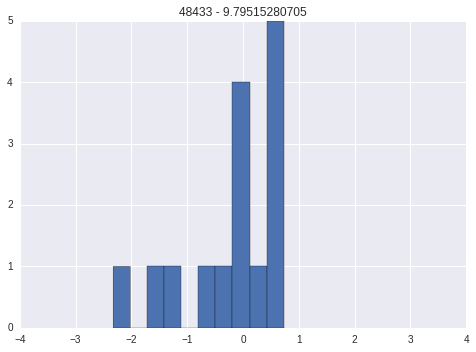

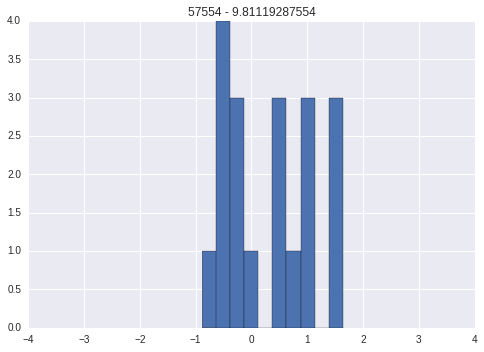

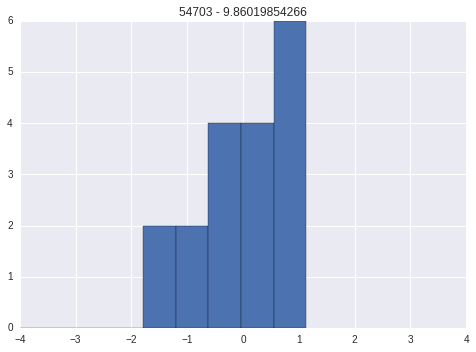

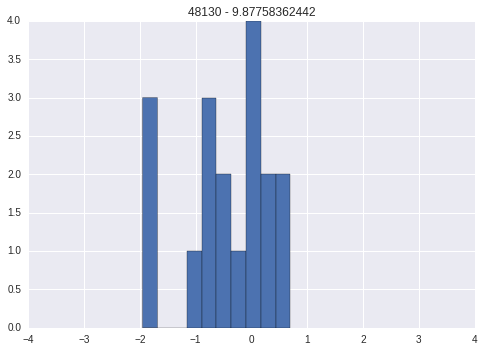

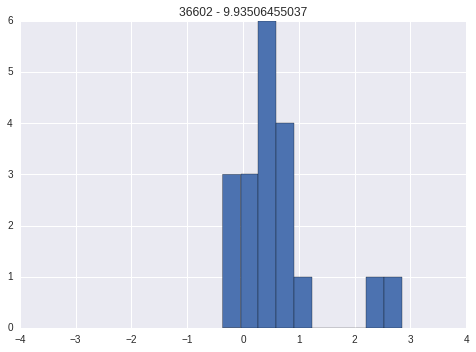

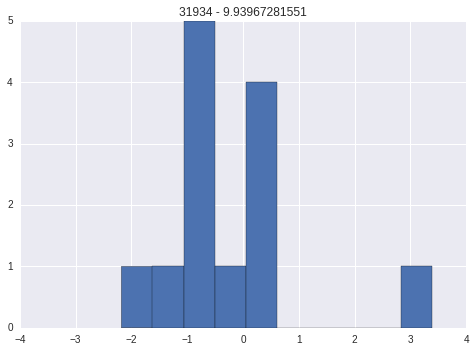

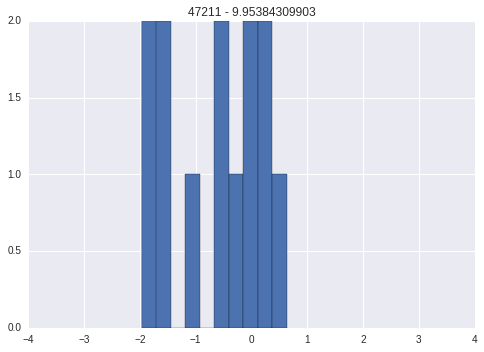

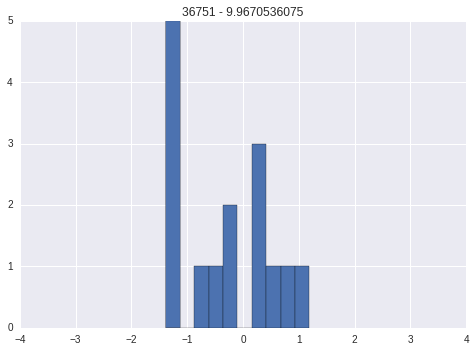

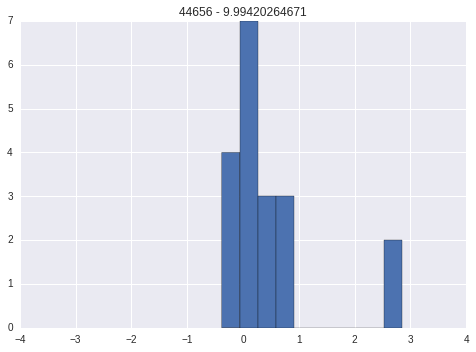

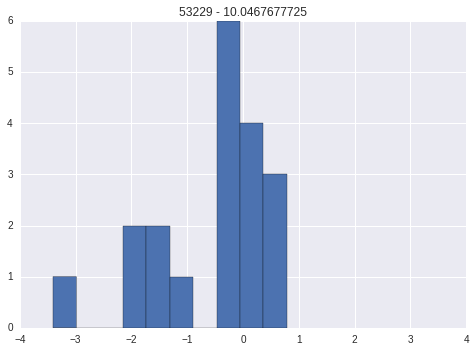

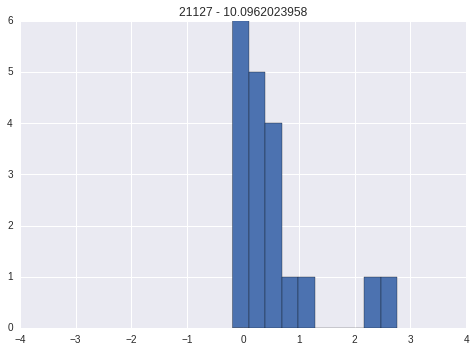

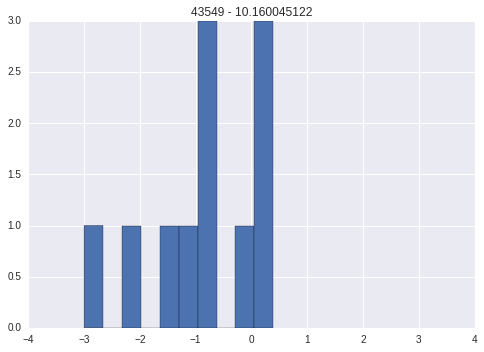

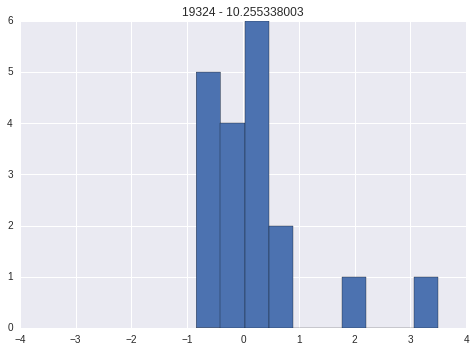

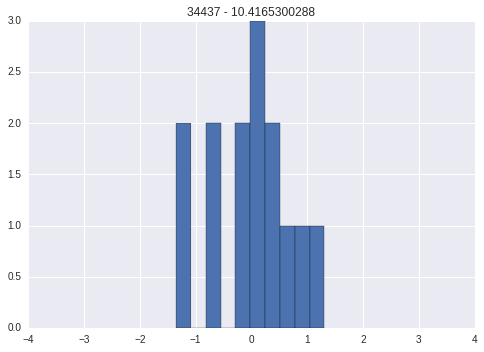

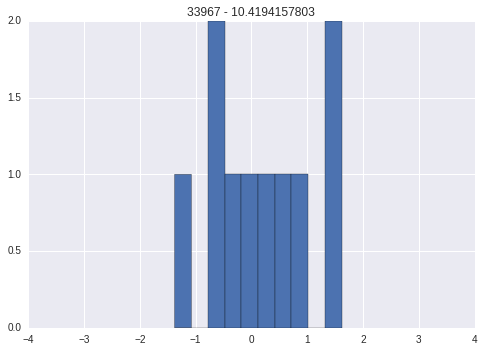

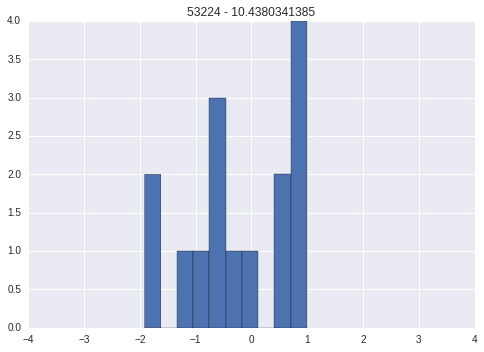

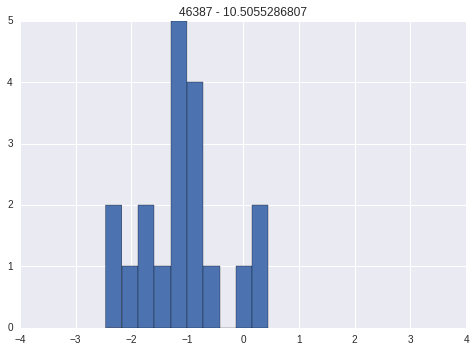

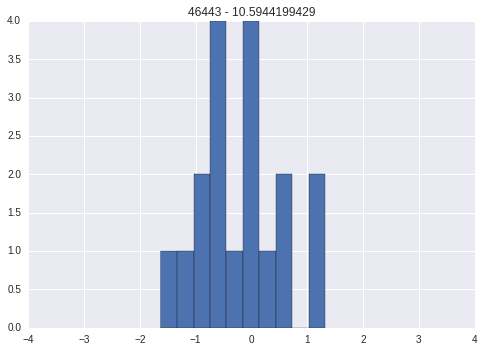

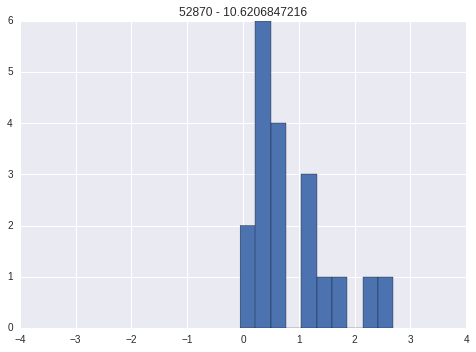

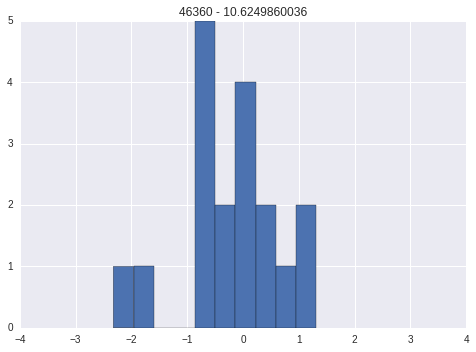

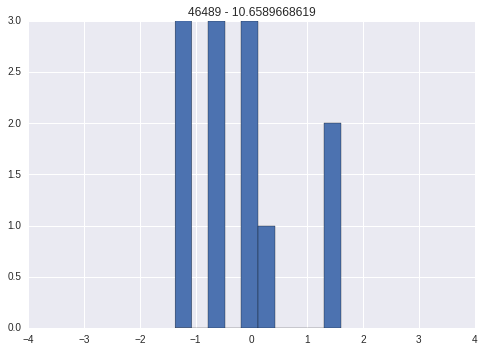

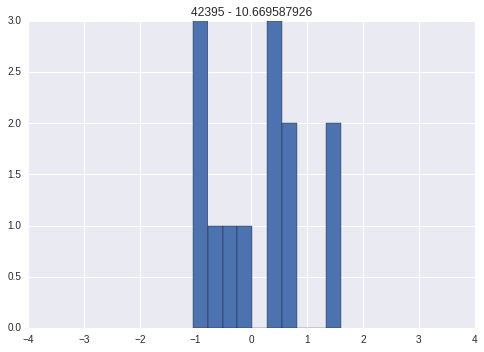

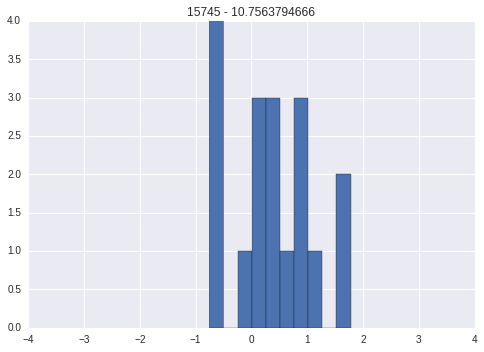

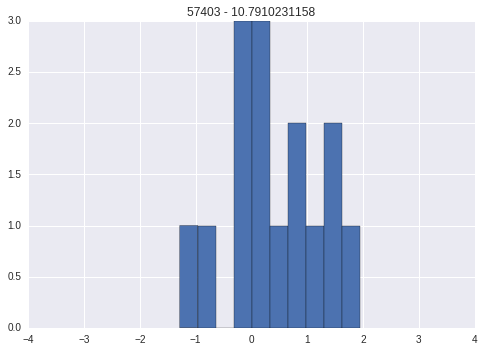

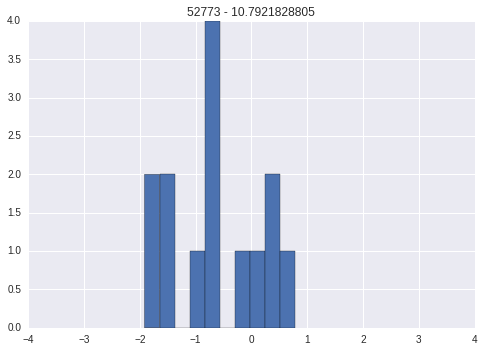

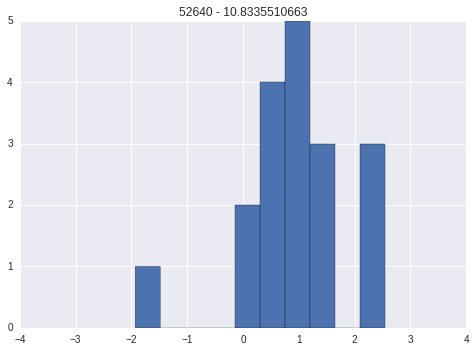

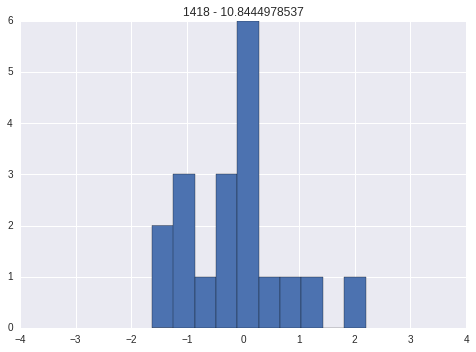

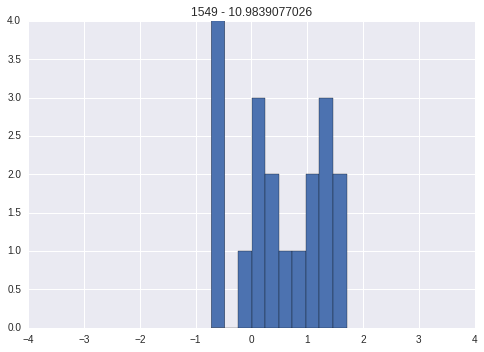

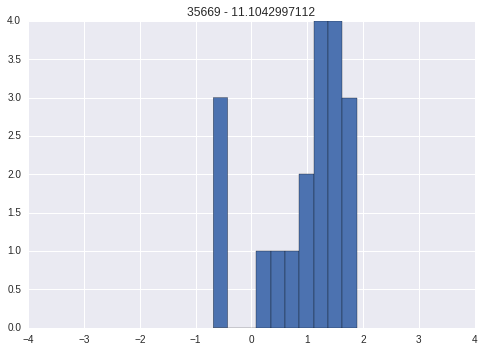

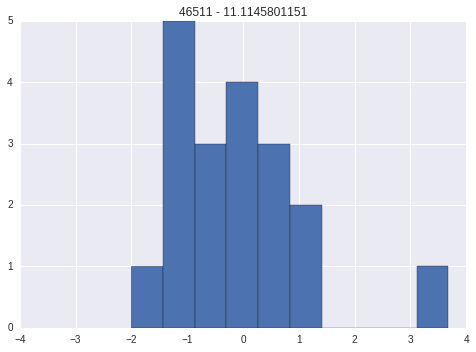

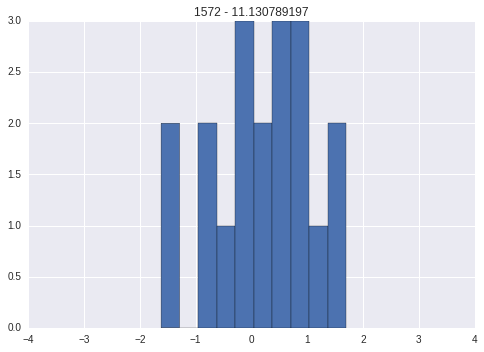

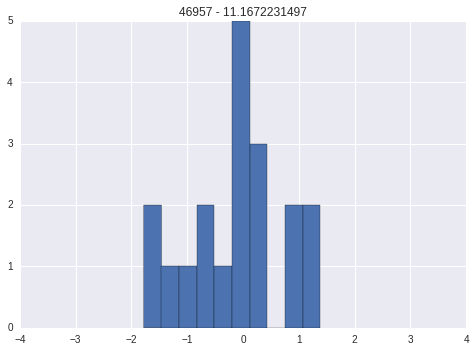

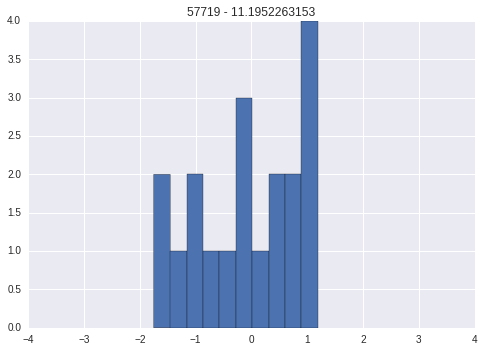

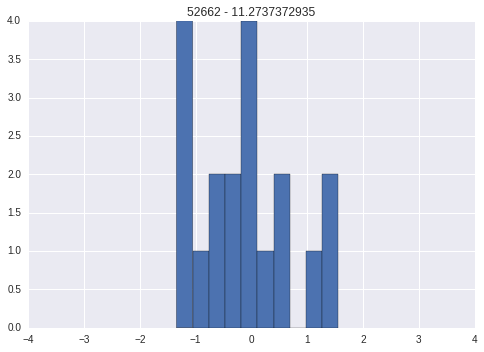

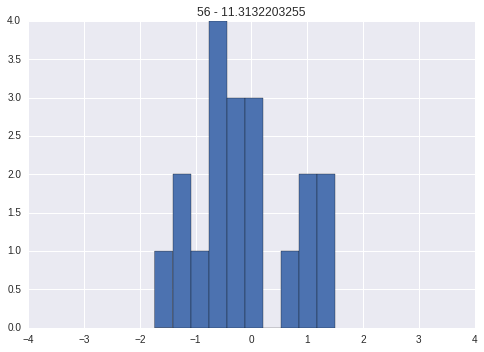

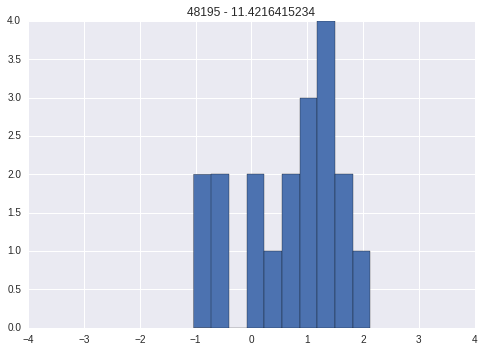

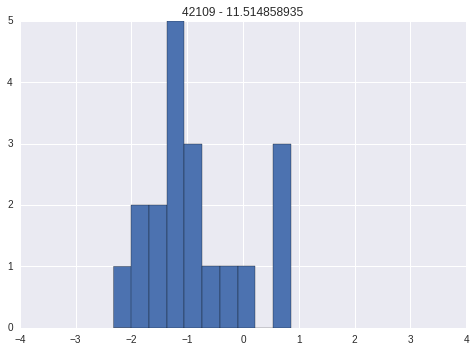

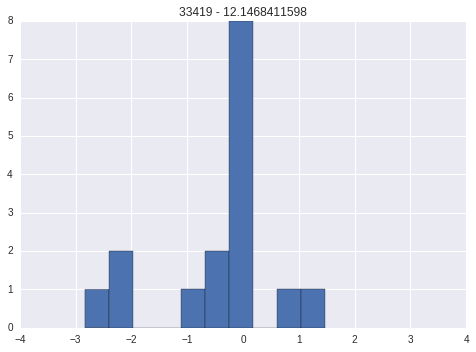

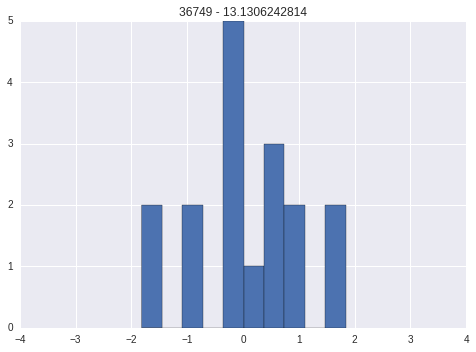

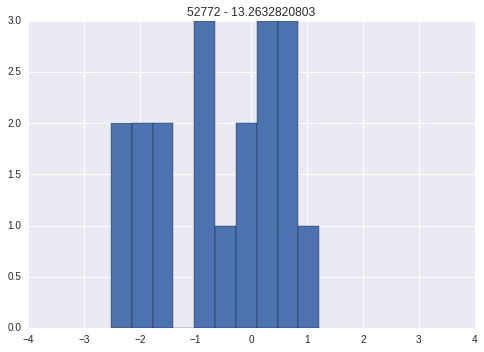

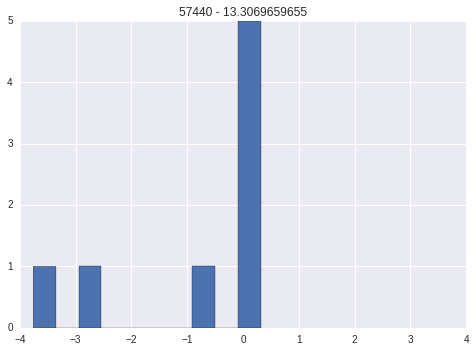

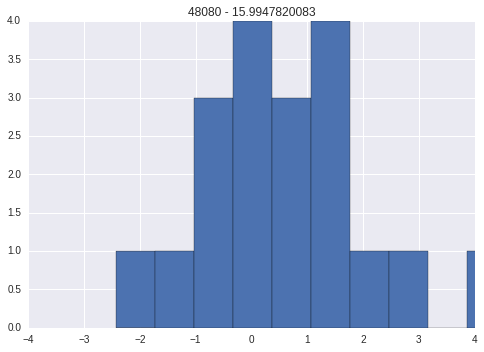

In [1036]:
scores = rel_score.loc[unreliable].sort_values()
scores_idx = list(scores.index)
for g in scores_idx:
    plt.hist(anchor_ppmet.loc[:,g].dropna(), bins = 10)
    plt.title(str(g) + ' - ' + str(scores.loc[g]))
    plt.xlim((-4,4))
    plt.show()

### interbatch variability

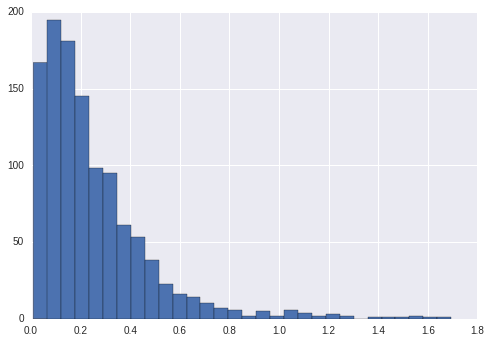

In [1054]:
batches = anchor_ppmet.index.get_level_values(0)
batches_size = list(set([b for b in batches if anchor_ppmet.loc[b].shape[0] > 1]))
inter_batch_diff = pd.DataFrame(columns=anchor_ppmet.columns)
for b in batches_size:
#     inter_batch_diff.loc[b] = abs(anchor_ppmet.fillna(-3).loc[b].iloc[0,:] - anchor_ppmet.fillna(-3).loc[b].iloc[1,:])
    inter_batch_diff.loc[b] = abs(anchor_ppmet.loc[b].iloc[0,:] - anchor_ppmet.loc[b].iloc[1,:])
inter_batch_diff = inter_batch_diff.loc[:,inter_batch_diff.notnull().sum()>1]
plt.hist(inter_batch_diff.dropna(how='all', axis=1).mean(), bins=30)
plt.show()
inter_batch_threshold = 0.8

ib_bad = set(inter_batch_diff.loc[:,inter_batch_diff.mean() > inter_batch_threshold].columns)

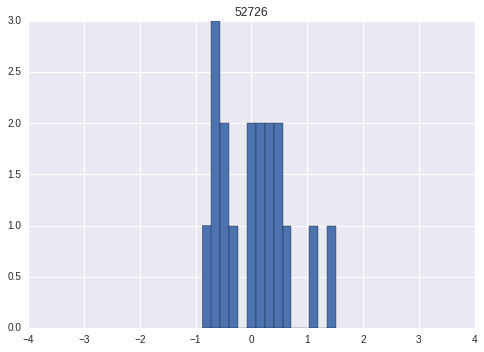

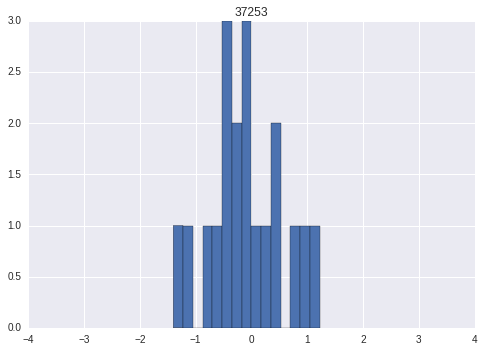

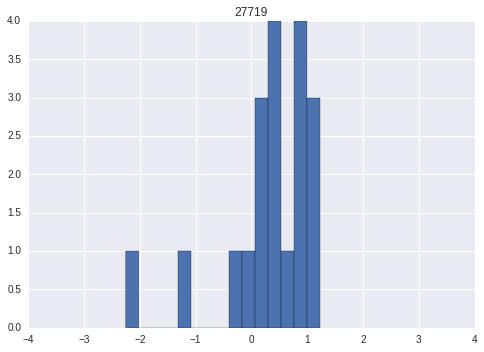

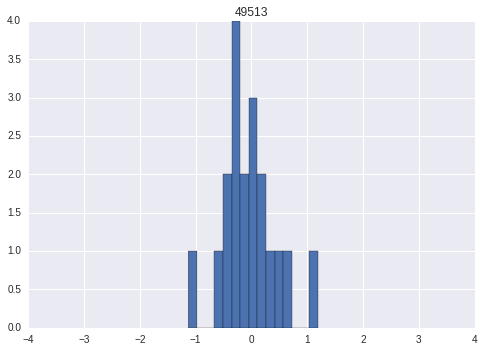

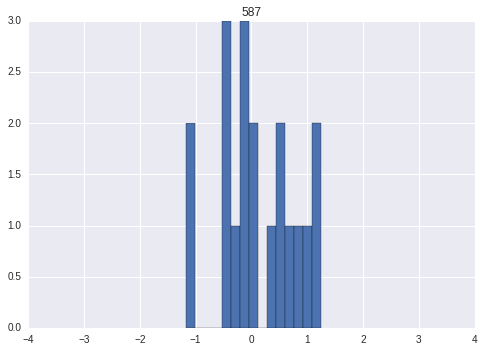

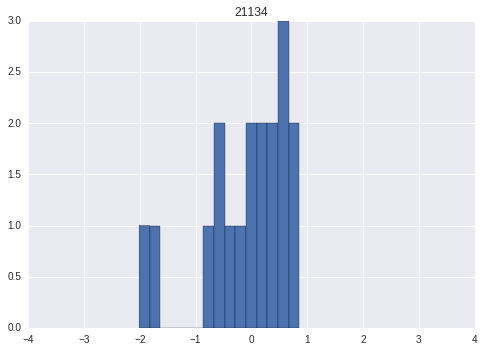

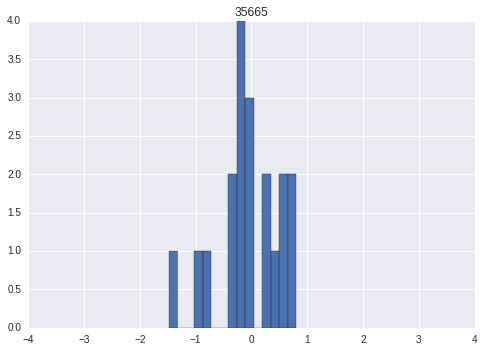

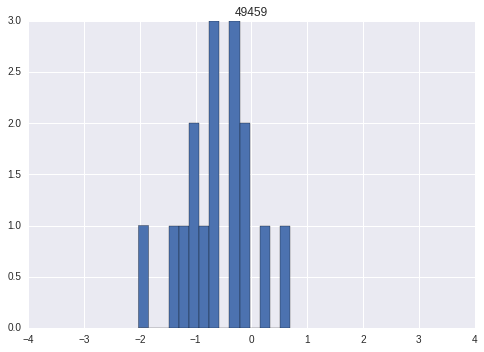

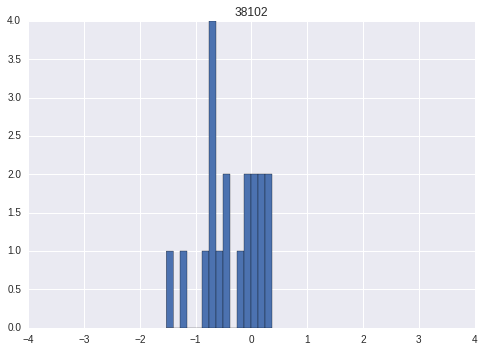

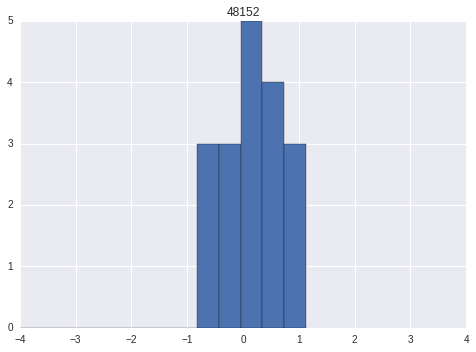

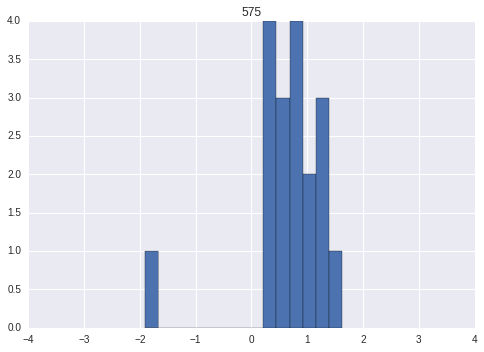

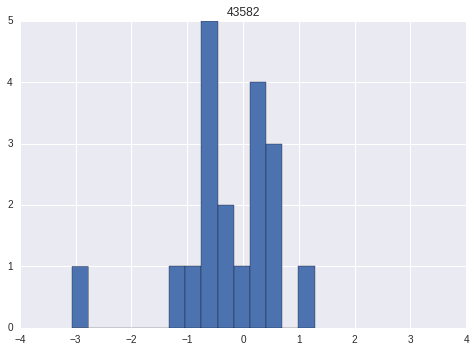

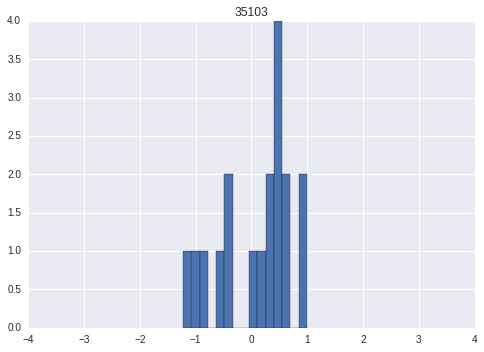

In [1055]:
for g in set(reliables).intersection(ib_bad):
    plt.xlim((-4,4))
    plt.hist(anchor_ppmet.loc[:,g].dropna(), bins=15)
    plt.title(g)
    plt.show()

In [1056]:
rel_score.loc[set(reliables).intersection(ib_bad)]

52726    8.573084
37253    7.681413
27719    7.220815
49513    5.381638
587      8.875623
21134    7.693569
35665    7.098083
49459    7.210020
38102    5.610280
48152    8.496445
575      6.454553
43582    8.573913
35103    7.840744
dtype: float64

In [1065]:
unreliable += list(rel_score.loc[set(reliables).intersection(ib_bad)].loc[rel_score.loc[set(reliables).intersection(ib_bad)] > 8].index)

In [1067]:
unreliable = set(unreliable)

In [1070]:
reliables = reliables.difference(unreliable)

In [1078]:
too_little_info = set(anchor_ppmet.columns).difference(set.union(reliables, unreliable))

In [1079]:
metabs_to_use = reliables.copy()
metabs_to_use.update(too_little_info)

In [1080]:
print "there are " + str(len(reliables)) + " reliable metabolites"
print "there are " + str(len(unreliable)) + " unreliable metabolites"
too_little_info = set(anchor_ppmet.columns).difference(set.union(reliables, unreliable))
print "there are " + str(len(too_little_info)) + " with too little information"

there are 1108 reliable metabolites
there are 70 unreliable metabolites
there are 73 with too little information


### coefficient of variation

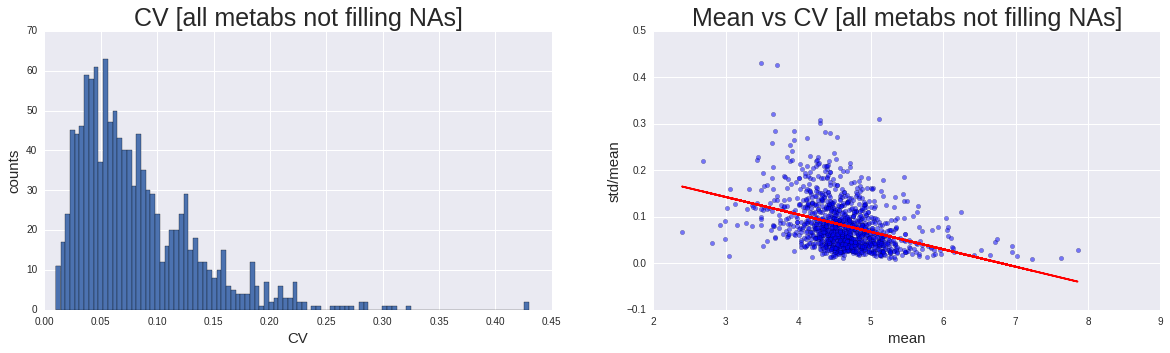

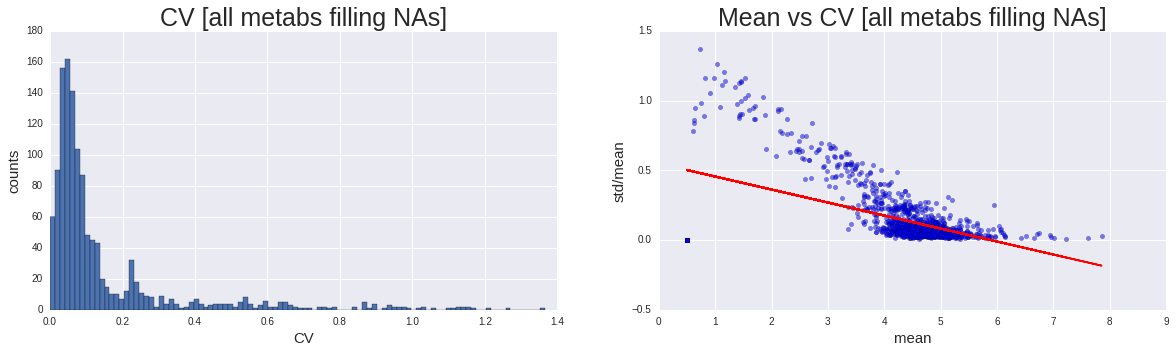

In [1361]:
temp_mean = anchor_ppmet_num_of_na[1].mean()+min_val*(-1) + 0.5
coef_of_var = anchor_ppmet_num_of_na[1].std() / temp_mean
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(coef_of_var, bins=100)
plt.title('CV [all metabs not filling NAs]', fontsize=25)
plt.xlabel('CV', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.subplot(1,2,2)
plt.scatter(temp_mean, coef_of_var, alpha=0.5)
plt.title('Mean vs CV [all metabs not filling NAs]', fontsize=25)
plt.xlabel('mean', fontsize=15)
plt.ylabel('std/mean', fontsize=15)
slope, intercept = np.polyfit(temp_mean, coef_of_var, 1)
abline_values = [slope * i + intercept for i in temp_mean]
plt.plot(temp_mean, abline_values, 'r')
plt.savefig('fig/CV_hist_and_mean_vs_CV_with_missing_vals.png')
plt.show()

temp_mean = anchor_ppmet_no_na.mean()+min_val*(-1)+0.5
coef_of_var = anchor_ppmet_no_na.std() / temp_mean
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(coef_of_var, bins=100)
plt.title('CV [all metabs filling NAs]', fontsize=25)
plt.xlabel('CV', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.subplot(1,2,2)
plt.scatter(temp_mean, coef_of_var, alpha=0.5)
plt.title('Mean vs CV [all metabs filling NAs]', fontsize=25)
plt.xlabel('mean', fontsize=15)
plt.ylabel('std/mean', fontsize=15)
slope, intercept = np.polyfit(temp_mean, coef_of_var, 1)
abline_values = [slope * i + intercept for i in temp_mean]
plt.plot(temp_mean, abline_values, 'r')
plt.savefig('fig/CV_hist_and_mean_vs_CV_no_missing_vals.png')
plt.show()

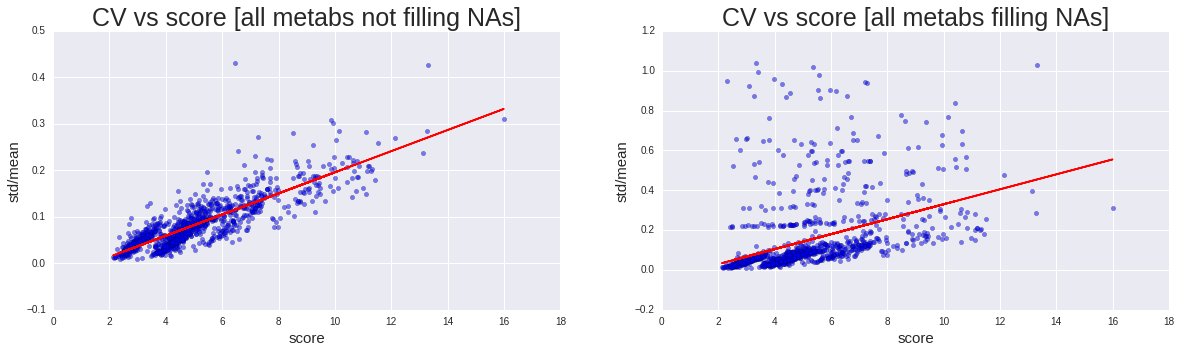

In [1363]:
coef_of_var = anchor_ppmet_num_of_na[5].std() / (anchor_ppmet_num_of_na[5].mean()+min_val*(-1) + 0.5)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(rel_score, coef_of_var, alpha=0.5)
plt.title('CV vs score [all metabs not filling NAs]', fontsize=25)
plt.xlabel('score', fontsize=15)
plt.ylabel('std/mean', fontsize=15)
slope, intercept = np.polyfit(rel_score, coef_of_var, 1)
abline_values = [slope * i + intercept for i in rel_score]
plt.plot(rel_score, abline_values, 'r')

plt.subplot(1,2,2)
coef_of_var = anchor_ppmet_num_of_na[5].fillna(min_val).std() / (anchor_ppmet_num_of_na[5].fillna(min_val).mean()+min_val*(-1) + 0.5)
plt.scatter(rel_score, coef_of_var, alpha=0.5)
plt.title('CV vs score [all metabs filling NAs]', fontsize=25)
plt.xlabel('score', fontsize=15)
plt.ylabel('std/mean', fontsize=15)
slope, intercept = np.polyfit(rel_score, coef_of_var, 1)
abline_values = [slope * i + intercept for i in rel_score]
plt.plot(rel_score, abline_values, 'r')
plt.savefig('fig/CV_vs_score.png')
plt.show()

#### using moving average

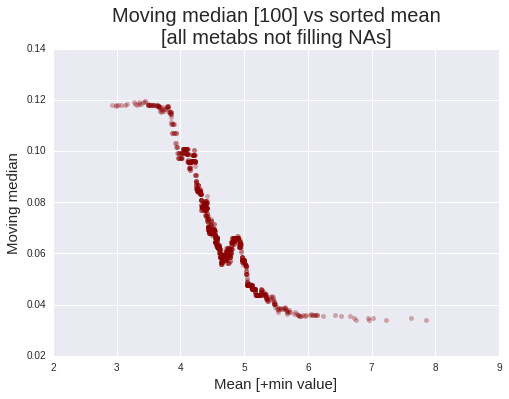

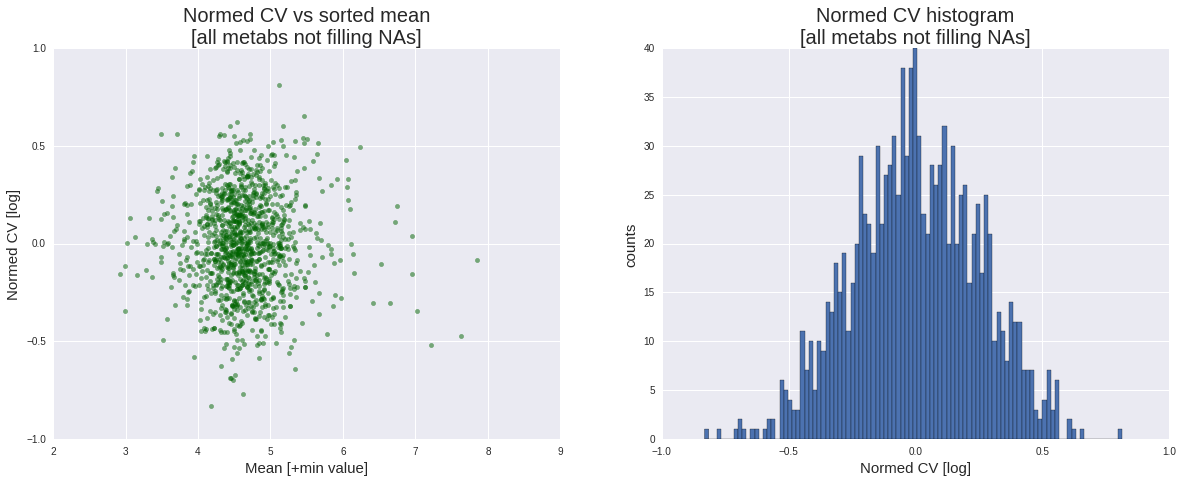

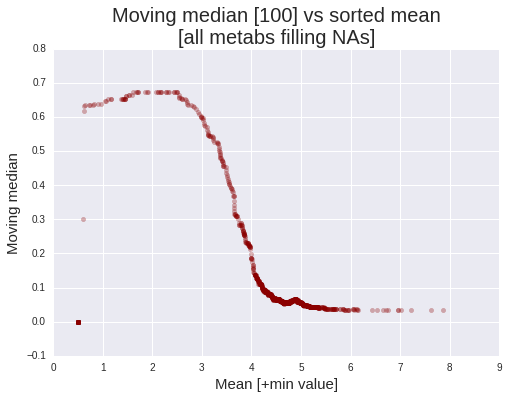

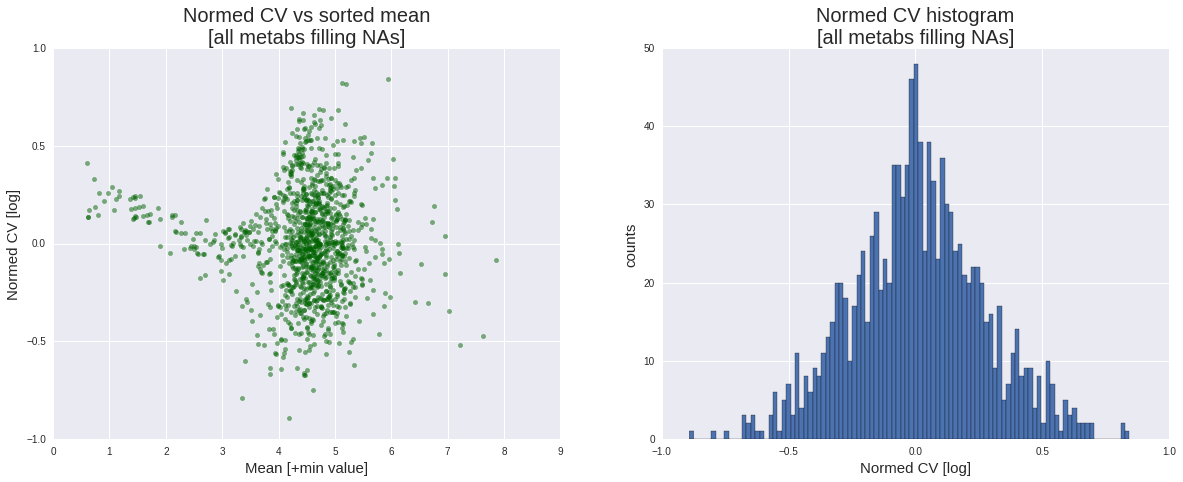

In [1504]:
temp_anchor = anchor_ppmet_num_of_na[5].copy()
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
plt.scatter(sorted_mean, moving_med, s=20, alpha=0.3, color='darkred')
plt.title('Moving median [100] vs sorted mean\n[all metabs not filling NAs]', fontsize=20)
plt.xlabel('Mean [+min value]', fontsize=15)
plt.ylabel('Moving median', fontsize=15)
plt.savefig('fig/CV_moving_median_vs_mean_not_filling_NAs.png')
plt.show()
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.scatter(sorted_mean, norm_cv_log, alpha=0.5, color='darkgreen')
plt.title('Normed CV vs sorted mean\n[all metabs not filling NAs]', fontsize=20)
plt.xlabel('Mean [+min value]', fontsize=15)
plt.ylabel('Normed CV [log]', fontsize=15)
plt.subplot(1,2,2)
plt.hist(norm_cv_log.dropna(), bins=100)
plt.title('Normed CV histogram\n[all metabs not filling NAs]', fontsize=20)
plt.xlabel('Normed CV [log]', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.savefig('fig/CV_normed_vs_mean_and_hist_not_filling_NAs.png')
plt.show()

temp_anchor = anchor_ppmet_no_na.copy()
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
plt.scatter(sorted_mean, moving_med, s=20, alpha=0.3, color='darkred')
plt.title('Moving median [100] vs sorted mean\n[all metabs filling NAs]', fontsize=20)
plt.xlabel('Mean [+min value]', fontsize=15)
plt.ylabel('Moving median', fontsize=15)
plt.savefig('fig/CV_moving_median_vs_mean_filling_NAs.png')
plt.show()
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.scatter(sorted_mean, norm_cv_log, alpha=0.5, color='darkgreen')
plt.title('Normed CV vs sorted mean\n[all metabs filling NAs]', fontsize=20)
plt.xlabel('Mean [+min value]', fontsize=15)
plt.ylabel('Normed CV [log]', fontsize=15)
plt.subplot(1,2,2)
plt.hist(norm_cv_log.dropna(), bins=100)
plt.title('Normed CV histogram\n[all metabs filling NAs]', fontsize=20)
plt.xlabel('Normed CV [log]', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.savefig('fig/CV_normed_vs_mean_and_hist_filling_NAs.png')
plt.show()

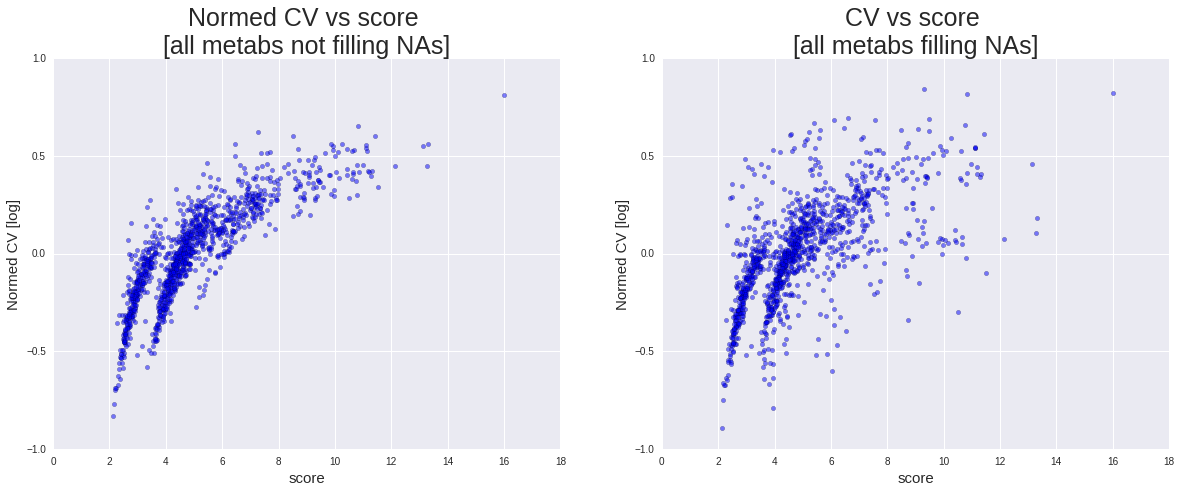

In [1515]:
temp_anchor = anchor_ppmet_num_of_na[5].copy()
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.scatter(rel_score, norm_cv_log.loc[rel_score.index], alpha=0.5)
plt.title('Normed CV vs score \n[all metabs not filling NAs]', fontsize=25)
plt.xlabel('score', fontsize=15)
plt.ylabel('Normed CV [log]', fontsize=15)

temp_anchor = anchor_ppmet_no_na.copy()
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
plt.subplot(1,2,2)
plt.scatter(rel_score, norm_cv_log.loc[rel_score.index], alpha=0.5)
plt.title('CV vs score \n[all metabs filling NAs]', fontsize=25)
plt.xlabel('score', fontsize=15)
plt.ylabel('Normed CV [log]', fontsize=15)
plt.savefig('fig/Normed_CV_vs_score.png')
plt.show()

#### saving values to data frame

In [1870]:
normed_cv_df = pd.DataFrame(None, index=anchor_ppmet.columns, columns=['NormedCV_no_fillna', 'NormedCV_fillna_min', 'NormedCV_fillna_5q'])

# metabolites with at least two non missing values
temp_anchor = anchor_ppmet_num_of_na[1].copy()
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
temp_cv_df = pd.DataFrame(norm_cv_log, columns=['NormedCV_no_fillna'])
normed_cv_df.loc[temp_cv_df.index, 'NormedCV_no_fillna'] = temp_cv_df['NormedCV_no_fillna']

# metabolites with at least one non missing value filled with min value
temp_anchor = anchor_ppmet_num_of_na[0].copy()
temp_anchor = temp_anchor.fillna(min_val)
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
temp_cv_df = pd.DataFrame(norm_cv_log, columns=['NormedCV_fillna_min'])
normed_cv_df.loc[temp_cv_df.index, 'NormedCV_fillna_min'] = temp_cv_df['NormedCV_fillna_min']

# metabolites with at least one non missing value filled with 5% quantile
temp_anchor = anchor_ppmet_num_of_na[0].copy()
quantile5 = temp_anchor.stack().quantile(.05)
temp_anchor = temp_anchor.fillna(quantile5)
temp_mean = temp_anchor.mean()+min_val*(-1) + 0.5
coef_of_var = temp_anchor.std() / temp_mean
sorted_mean = temp_mean.sort_values()
coef_of_var = coef_of_var.loc[sorted_mean.index]
moving_med = compute_moving_average(coef_of_var, window_size=100, method=np.median)
norm_cv = coef_of_var/moving_med
norm_cv_log = np.log10(norm_cv)
temp_cv_df = pd.DataFrame(norm_cv_log, columns=['NormedCV_fillna_5q'])
normed_cv_df.loc[temp_cv_df.index, 'NormedCV_fillna_5q'] = temp_cv_df['NormedCV_fillna_5q']

# reliability score computed by me
normed_cv_df = pd.concat((normed_cv_df, rel_score), axis=1)
normed_cv_df.rename(columns={0: 'rel_score'}, inplace=True)
normed_cv_df.index.rename('COMP_ID', inplace=True)

Utils.Write('tmp_files/normedCV_scores.dat', normed_cv_df)

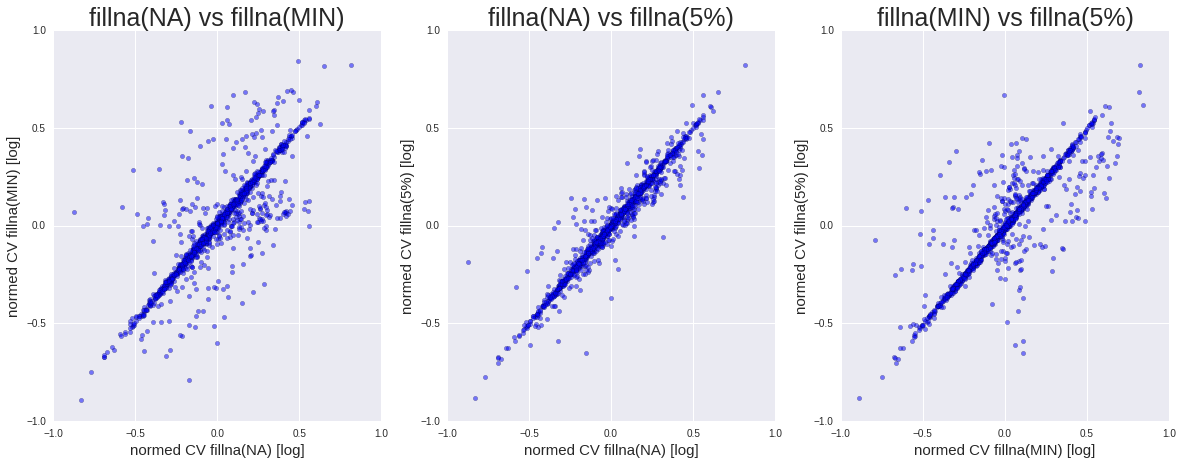

In [1855]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.scatter(normed_cv_df.NormedCV_no_fillna, normed_cv_df.NormedCV_fillna_min, alpha=0.5)
plt.title('fillna(NA) vs fillna(MIN)', fontsize=25)
plt.xlabel('normed CV fillna(NA) [log]', fontsize=15)
plt.ylabel('normed CV fillna(MIN) [log]', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(normed_cv_df.NormedCV_no_fillna, normed_cv_df.NormedCV_fillna_5q, alpha=0.5)
plt.title('fillna(NA) vs fillna(5%)', fontsize=25)
plt.xlabel('normed CV fillna(NA) [log]', fontsize=15)
plt.ylabel('normed CV fillna(5%) [log]', fontsize=15)
plt.subplot(1,3,3)
plt.scatter(normed_cv_df.NormedCV_fillna_min, normed_cv_df.NormedCV_fillna_5q, alpha=0.5)
plt.title('fillna(MIN) vs fillna(5%)', fontsize=25)
plt.xlabel('normed CV fillna(MIN) [log]', fontsize=15)
plt.ylabel('normed CV fillna(5%) [log]', fontsize=15)

plt.savefig('fig/NormedCV_scatter_plots.png')
plt.show()

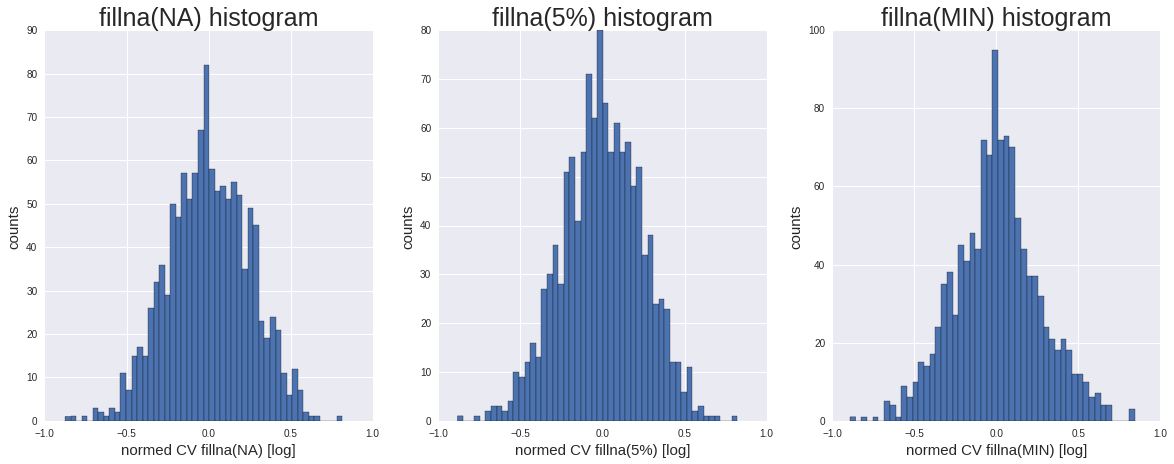

In [1858]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.hist(normed_cv_df.NormedCV_no_fillna.dropna(), bins=50)
plt.title('fillna(NA) histogram', fontsize=25)
plt.xlabel('normed CV fillna(NA) [log]', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.subplot(1,3,2)
plt.hist(normed_cv_df.NormedCV_fillna_5q.dropna(), bins=50)
plt.title('fillna(5%) histogram', fontsize=25)
plt.xlabel('normed CV fillna(5%) [log]', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.subplot(1,3,3)
plt.hist(normed_cv_df.NormedCV_fillna_min.dropna(), bins=50)
plt.title('fillna(MIN) histogram', fontsize=25)
plt.xlabel('normed CV fillna(MIN) [log]', fontsize=15)
plt.ylabel('counts', fontsize=15)

plt.savefig('fig/NormedCV_histograms.png')
plt.show()

## Find relevant FD_CID

In [74]:
all_fd_cid = read_csv('../all_fd_connid.csv')
ppmet = Utils.Load('tmp_files/ppmet_483x820.df')
pnp_ids = Utils.Load('tmp_files/pnp_ids.df')

corrected_pnp_ids = concat((pnp_ids[pnp_ids.StudyTypeID != 50],pnp_ids[pnp_ids.StudyTypeID == 50].reset_index().groupby('ConnectionID').\
                            apply(lambda x: x.loc[x.StorageDT.argmin()]).set_index('CLIENT_IDENTIFIER')))
corrected_all_fd_cid = all_fd_cid.copy()
late_date_filler = '2020-01-01'
corrected_all_fd_cid['StorageDT'] = corrected_all_fd_cid['StorageDT'].fillna(late_date_filler)
corrected_all_fd_cid['StorageDT'] = corrected_all_fd_cid['StorageDT'].apply(lambda x: pd.to_datetime(x))
print corrected_all_fd_cid.shape
corrected_all_fd_cid = corrected_all_fd_cid.groupby(['ConnectionID', 'UserID']).apply(lambda x: x.loc[x.StorageDT.argmin()])
relevant_pnp_ids = corrected_pnp_ids.loc[ppmet.index]
metabolon_fd_cid = relevant_pnp_ids.merge(corrected_all_fd_cid, on=['UserID', 'ConnectionID'])
metabolon_fd_cid['FD_CID'] = metabolon_fd_cid.DnaID.astype(str) + '_' + metabolon_fd_cid.ConnectionID.astype(str)

(1969, 16)


In [1116]:
metabolon_fd_cid.shape

(483, 21)

## KEGG

In [1114]:
kegg = KEGG_data_holder()

2017-11-28 12:01:06.233201 - [KEGG_data_holder._build_dicts] building url drug_pathway
2017-11-28 12:01:08.167480 - [KEGG_data_holder._build_dicts] building url pathway_ko
2017-11-28 12:01:16.130278 - [KEGG_data_holder._build_dicts] building url drug_ko
2017-11-28 12:01:18.927310 - [KEGG_data_holder._build_dicts] building url reaction_ko
2017-11-28 12:01:21.231723 - [KEGG_data_holder._build_dicts] building url compound_reaction
2017-11-28 12:01:25.565391 - [KEGG_data_holder._build_dicts] building url compound_pathway
2017-11-28 12:01:27.759869 - [KEGG_data_holder._build_dicts] building url compound_module
2017-11-28 12:01:28.643832 - [KEGG_data_holder._build_dicts] building url module_ko
2017-11-28 12:01:29.792562 - [KEGG_data_holder._build_KEGG_COG_dict] loading KEGG_COG dict
2017-11-28 12:04:00.082308 - [KEGG_data_holder._build_KEGG_COG_dict] parsing ko_bacgene dict
2017-11-28 12:04:17.244838 - [KEGG_data_holder._link_dicts] linking compound_pathway, pathway_ko
2017-11-28 12:04:17.51

In [1115]:
kegg._merge_dicts('compound', 'ko')
kegg._merge_dicts('ko', 'compound')
kegg.dicts.keys()

['compound_reaction_ko',
 'ko_bacgene',
 'compound_ko',
 'ko_pathway_compound',
 'KEGG_COG',
 'ko_module_compound',
 'compound_module_ko',
 'compound_pathway_ko',
 'ko_compound',
 'drug_pathway',
 'pathway_ko',
 'drug_ko',
 'reaction_ko',
 'compound_reaction',
 'ko_reaction_compound',
 'compound_pathway',
 'compound_module',
 'module_ko',
 'drug_pathway_ko']

### Explore KEGG data

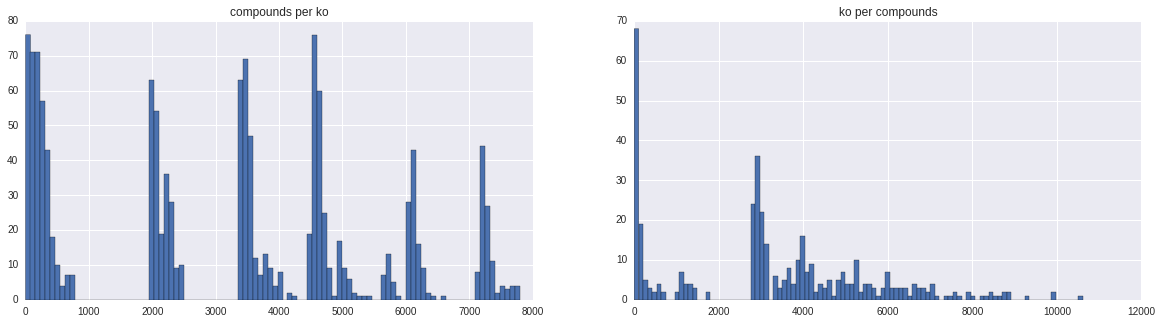

In [1119]:
# need to pick a threshold for screening compounds and KOs
our_compounds = ['cpd:' + str(c) for c in metabs.KEGG.dropna().values]
com_per_ko = [len(kegg.dicts['ko_pathway_compound'][c]) for c in kegg.dicts['ko_pathway_compound']]
com_per_ko += [len(kegg.dicts['ko_reaction_compound'][c]) for c in kegg.dicts['ko_reaction_compound']]
com_per_ko += [len(kegg.dicts['ko_module_compound'][c]) for c in kegg.dicts['ko_module_compound']]
com_per_ko = list(set(com_per_ko)) # 500
ko_per_com = [len(kegg.dicts['compound_pathway_ko'][c]) for c in kegg.dicts['compound_pathway_ko'] if c in our_compounds]
ko_per_com += [len(kegg.dicts['compound_reaction_ko'][c]) for c in kegg.dicts['compound_reaction_ko'] if c in our_compounds]
ko_per_com += [len(kegg.dicts['compound_module_ko'][c]) for c in kegg.dicts['compound_module_ko'] if c in our_compounds]
ko_per_com = list(set(ko_per_com)) # 2000

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(com_per_ko, bins=100)
plt.title('compounds per ko')
plt.subplot(1,2,2)
plt.hist(ko_per_com, bins=100)
plt.title('ko per compounds')
plt.show()

In [311]:
METABOLON_FIG_PATH = METABOLON_DIR + '/fig/'
def metabolite_to_compound(metabolite):
    try:
        compound = str(metabs.loc[metabolite].KEGG)
        if compound == 'nan':
            return None
        return compound
    except:
        print ("metabolite " + metabolite + " does not exist in our dataset.")
        return None

def get_kegg_dbs_per_compound(compound, KEGG_database):
    kegg_compound = metabolite_to_compound(compound)
    if (kegg_compound is None):
        return []
    #drugs KEGG identifier start with 'D', compounds start with 'C'
    if kegg_compound[0] == 'D':
        c_d = 'drug'
    else:
        c_d = 'compound'
    dic_name = c_d + '_' + KEGG_database
    kegg_pref = 'cpd:' if c_d == 'compound' else 'dr:'
    kegg_compound = kegg_pref + kegg_compound
    if dic_name not in kegg.get_dicts():
        return []
    if kegg_compound not in kegg.get_dicts()[dic_name]:
        return []
    return kegg.get_dicts()[dic_name][kegg_compound]

def autolabel(rects, axx):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axx.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), 
                ha='center', va='bottom')
    return axx

def clip_X_percent(arr, X, top='top'):
    arr = arr[arr>0]
    if top == 'top':
        arr = arr.clip(max=np.percentile(arr, X))
    elif top == 'bottom':
        arr = arr.clip(min=np.percentile(arr, X))
    return arr

# how many compounds with KEGG?
sns.set_style("darkgrid")

num_of_metabs = metabs.shape[0]
only_kegg = metabs.KEGG[metabs.KEGG.isnull() == False]

# out of the compounds with kegg, how many have some data? (reaction/pathway/module)
# and many have downstream bacterial genes
n_comp_w_db = {}
n_comp_w_db_w_bg = {}
db_colors = {'reaction': 'blue', 'pathway':'red', 'module':'green'}
for db in ['reaction', 'pathway', 'module']:
    comp_w_db = [get_kegg_dbs_per_compound(i, db) for i in only_kegg.index]
    n_comp_w_db[db] = len([1 for i in comp_w_db if len(i) > 0])
    comp_w_db_w_bac_genes = np.array([sum([len(kegg.get_link_dicts(db + '_ko', 'ko_bacgene', r)) for r in c]) 
                            for c in comp_w_db])

    n_comp_w_db_w_bg[db] = len([1 for i in comp_w_db_w_bac_genes if i > 0])

    # histograms of number of reactions/pathways/modules per compound
    n_db_per_compound = np.array([len(r) for r in comp_w_db if len(r) > 0])
    n_db_per_compound_95 = clip_X_percent(n_db_per_compound, 95, 'top')
    fig, ax = plt.subplots()
    ax.hist(n_db_per_compound_95, bins=15, color = db_colors[db])
    ax.set_ylabel('Number of compounds')
    ax.set_xlabel('Number of ' + db + 's')
    ax.set_title('Number of ' + db + 's per compound clipped at 95%')
    labels = ax.get_xticks().tolist()
    labels[-1] = '>' + str(labels[-1])
    ax.set_xticklabels(labels)
    plt.savefig(METABOLON_FIG_PATH + db + 's_per_compounds.png', bbox_inches='tight')

    # foreach kegg database, distribution of number of bac genes
    db_set = set([r for sublist in comp_w_db for r in sublist])
    bac_gene_per_db = np.array([len(kegg.get_link_dicts(db + '_ko', 'ko_bacgene', r)) for r in db_set])
    bac_gene_per_db_95 = clip_X_percent(bac_gene_per_db, 95, 'top')
    fig, ax = plt.subplots()
    ax.hist(bac_gene_per_db_95, bins=50, color = db_colors[db])
    ax.set_ylabel('Number of ' + db + 's')
    ax.set_xlabel('Number of bacterial genes')
    ax.set_title('Number of bacterial genes per ' + db + ' clipped at 95%')
    labels = ax.get_xticks().tolist()
    labels[-1] = '>' + str(labels[-1])
    ax.set_xticklabels(labels)
    plt.savefig(METABOLON_FIG_PATH + 'bac_gene_per_' + db + '.png', bbox_inches='tight')

    # KOs per kegg db
    ko_per_db = np.array([len(kegg.get_dicts()[db + '_ko'][d]) for d in kegg.get_dicts()[db + '_ko']])
    ko_per_db_95 = clip_X_percent(ko_per_db, 95, 'top')
    fig, ax = plt.subplots()
    ax.hist(ko_per_db_95, bins=15, color = db_colors[db])
    ax.set_ylabel('Number of ' + db + 's')
    ax.set_xlabel('Number of KOs')
    ax.set_title('Number of KOs per ' + db + ' clipped at 95%')
    labels = ax.get_xticks().tolist()
    labels[-1] = '>' + str(labels[-1])
    ax.set_xticklabels(labels)
    plt.savefig(METABOLON_FIG_PATH + 'KOs_per_' + db + '.png', bbox_inches='tight')

# kegg data of compounds
num_of_kegg_metabs = only_kegg.shape[0]
num_of_kegg_compounds = len([c for c in only_kegg if c[0] == 'C'])
num_of_kegg_drugs = len([d for d in only_kegg if d[0] == 'D'])
nums = {'total metabs':num_of_metabs, 'metabs with KEGG id':num_of_kegg_metabs,
        'KEGG compounds':num_of_kegg_compounds, 'KEGG drugs':num_of_kegg_drugs}
ind = np.arange(4)
width = 0.7       
fig, ax = plt.subplots()
rects1 = ax.bar(ind, nums.values(), width, color='r')
ax.set_ylabel('Number of metabolites')
ax.set_title('Metabolites by KEGG')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(nums.keys())               
ax = autolabel(rects1, ax)
plt.savefig(METABOLON_FIG_PATH + 'metabolites_kegg_description.png', bbox_inches='tight')

ind = np.arange(3)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind, n_comp_w_db.values(), width, color='r')
rects2 = ax.bar(ind + width, n_comp_w_db_w_bg.values(), width, color='b')
ax.set_ylabel('Number of metabolites')
ax.set_title('Metabolites KEGG potential')
ax.set_xticks(ind + width)
ax.set_xticklabels(n_comp_w_db.keys())
ax.legend((rects1[0], rects2[0]), ('compounds with KEGG data', 'compounds with bac genes'))              
ax = autolabel(rects1, ax)
ax = autolabel(rects2, ax)
plt.savefig(METABOLON_FIG_PATH + 'metabolites_kegg_potential.png', bbox_inches='tight')

# genes per KO
bac_genes_per_ko = np.array([len(kegg.get_dicts()['ko_bacgene'][d]) for d in kegg.get_dicts()['ko_bacgene']])
bac_genes_per_ko_95 = clip_X_percent(bac_genes_per_ko, 95, 'top')
fig, ax = plt.subplots()
ax.hist(bac_genes_per_ko_95, bins=50, color = 'grey')
ax.set_ylabel('Number of KOs')
ax.set_xlabel('Number of bacterial genes')
ax.set_title('Number of bacterial genes per KO clipped at 95%')
labels = ax.get_xticks().tolist()
labels[-1] = '>' + str(labels[-1])
ax.set_xticklabels(labels)
plt.savefig(METABOLON_FIG_PATH + 'bacterial_genes_per_KO.png', bbox_inches='tight')

2017-10-03 09:42:23.358231 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.370074 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.382861 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.393033 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.399038 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.400313 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.401477 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.410630 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.424780 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.426819 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.428793 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.433000 - The following link is unavailable: drug_reaction
2017-10-03 09:42:23.437476 - The following link is unavailable: 

### KO data exploration

In [247]:
kos_dict = Utils.Load('../KEGG_DB_12_12_2017/kos_dict.dat')
kos_genes_dict = Utils.Load('../KEGG_DB_12_12_2017/kos_genes_dict.dat')
KEGG_FIG_DIR = '../KEGG_DB_12_12_2017/figs/'
if not os.path.exists(KEGG_FIG_DIR): os.makedirs(KEGG_FIG_DIR)

In [248]:
ngenes = [len(kos_genes_dict[g]) for g in kos_genes_dict]
ngenes = np.array(ngenes)

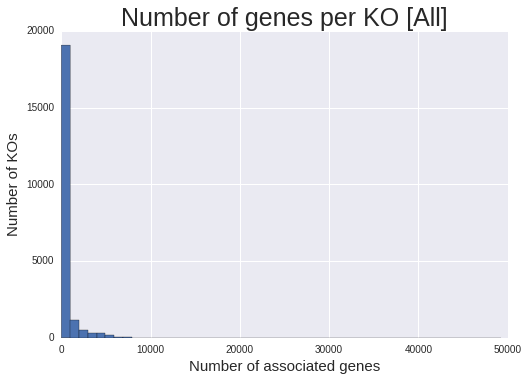

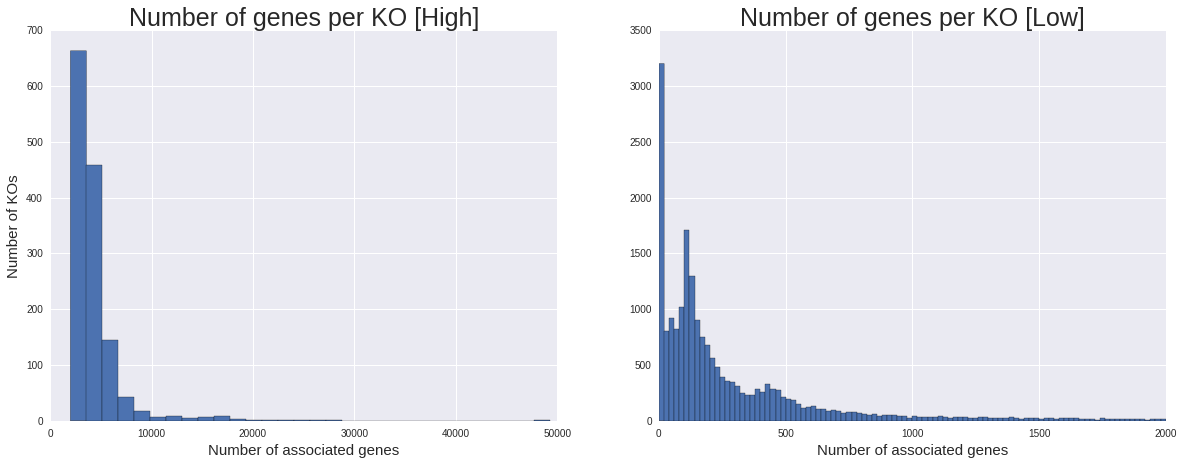

In [249]:
plt.hist(ngenes, bins=50)
plt.title('Number of genes per KO [All]', fontsize=25)
plt.ylabel('Number of KOs', fontsize=15)
plt.xlabel('Number of associated genes', fontsize=15)
plt.savefig(KEGG_FIG_DIR + '/hist_number_of_genes_per_ko.png')
plt.show()
plt.figure(figsize=((20,7)))
plt.subplot(1,2,1)
plt.hist(ngenes[ngenes > 2000], bins=30)
plt.ylabel('Number of KOs', fontsize=15)
plt.xlabel('Number of associated genes', fontsize=15)
plt.title('Number of genes per KO [High]', fontsize=25)
plt.subplot(1,2,2)
plt.hist(ngenes[ngenes <= 2000], bins=100)
plt.title('Number of genes per KO [Low]', fontsize=25)
plt.xlabel('Number of associated genes', fontsize=15)
plt.savefig(KEGG_FIG_DIR + '/hist_number_of_genes_per_ko_high-low.png')
plt.show()

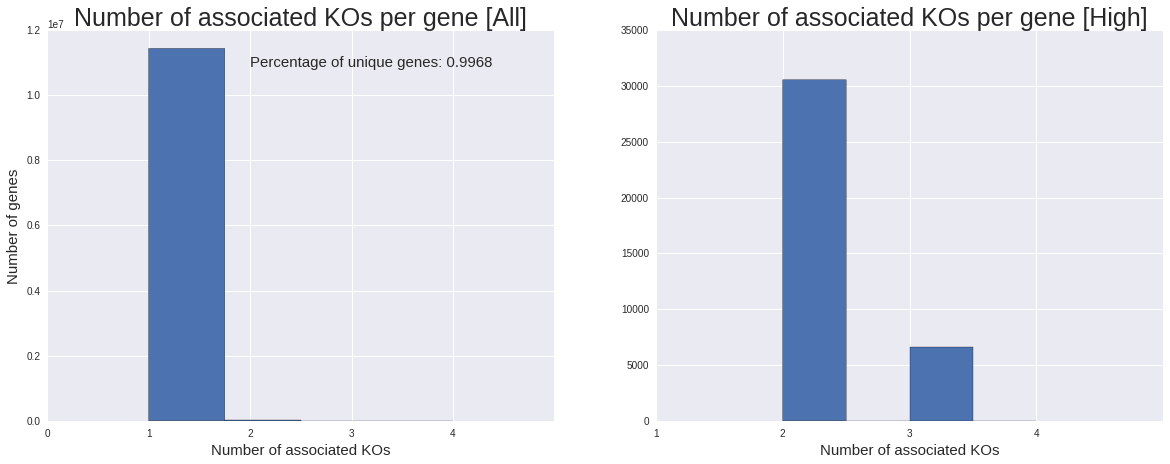

In [250]:
# percentage of genes associated to more than one KO
genes_full_list = []
for g in kos_genes_dict:
    genes_full_list += kos_genes_dict[g]
genes_n_appear = Counter(genes_full_list)
genes_n_appear_arr = np.array(genes_n_appear.values())

n_genes_one = sum([1 for g in genes_n_appear_arr if g ==1])

plt.figure(figsize=((20,7)))
plt.subplot(1,2,1)
plt.hist(genes_n_appear_arr, bins=4)
plt.xticks(range(min(genes_n_appear_arr)-1, max(genes_n_appear_arr)+1))
# sns.distplot(genes_n_appear_arr, hist=True, label='noam')
plt.ylabel('Number of genes', fontsize=15)
plt.xlabel('Number of associated KOs', fontsize=15)
plt.title('Number of associated KOs per gene [All]', fontsize=25)
plt.xlim((min(genes_n_appear_arr)-1, max(genes_n_appear_arr)+1))
plt.text(2, len(genes_n_appear_arr)*0.95, "Percentage of unique genes: %0.4f" %  (float(n_genes_one) / len(genes_n_appear)), fontsize=15)
plt.subplot(1,2,2)
plt.hist(genes_n_appear_arr[genes_n_appear_arr > 1], bins=4)
plt.title('Number of associated KOs per gene [High]', fontsize=25)
plt.xlim((1, max(genes_n_appear_arr)+1))
plt.xticks(range(1, max(genes_n_appear_arr)+1))
plt.xlabel('Number of associated KOs', fontsize=15)
plt.savefig(KEGG_FIG_DIR + '/hist_number_of_KO_per_gene_All-High.png')
plt.show()

In [251]:
with open('../KEGG_DB_12_12_2017/KEGG_allgenes.txt', 'w') as handle:
    for g in set(genes_full_list):
        handle.write(g + '\n')

In [ ]:
# create a dictionary of genes lengths by reading gene dna file and count sequence letters

In [ ]:
# go over the kegg aa file and take only genes found in dna file, intersect the genes names (start of them)

## original analysis by pathways and reactions

In [149]:
with open('9_9_2017/GSEA_bac_genes_7_9_2017.df', 'rb') as handle:
    gsea_old = pickle.load(handle)

qs = fdr_correction(gsea_old.test_pval)
gsea_old['q_value'] = qs[1]
gsea_old[gsea_old.test_pval < 1e-100].sort_values(['test_pval'])

,CompID,KEGGID,KEGG_db_type,KEGG_db_ID,n_genes_in_kegg,n_genes_in_test,n_genes_rest,test_pval,test_statistic,stat_test,q_value
2155,18280,C00628,pathway,path:map01100,1050775,441847,2741393,0.000000e+00,5.827948e+11,mannwhitney,0.000000e+00
2590,57745,C07086,pathway,path:map01100,1050775,442807,2749705,0.000000e+00,5.816409e+11,mannwhitney,0.000000e+00
1637,15749,C05629,pathway,path:map01120,286545,119302,3096496,1.026620e-284,1.733698e+11,mannwhitney,1.117305e-281
2568,20694,C00209,pathway,path:map01100,1050775,446116,2771128,7.104546e-241,5.990535e+11,mannwhitney,5.799085e-238
2591,57745,C07086,pathway,path:map01120,286545,118359,3073761,2.364592e-199,1.725396e+11,mannwhitney,1.544079e-196
1837,4970,C00108,pathway,path:map01100,1050775,442127,2740085,1.470103e-171,5.899210e+11,mannwhitney,7.999808e-169
2514,1124,C00137,pathway,path:map01100,1050775,446116,2771128,5.179372e-156,6.028175e+11,mannwhitney,2.415807e-153
2199,15443,C00191,pathway,path:map01100,1050775,446116,2771128,2.943863e-128,6.042681e+11,mannwhitney,1.201464e-125
2980,1567,C05584,pathway,path:map01100,1050775,446062,2770666,5.279187e-109,6.051956e+11,mannwhitney,1.915172e-106


## Number of bacterial genes mapped to more than one KO

Number of bacterial genes with one KO: 4139764
Number of bacterial genes with more than one KO: 19394.0
Average number of KOs per bacterial genes that have more than one KO: 2.02598741879
Number of bacterial genes with no KO: 0


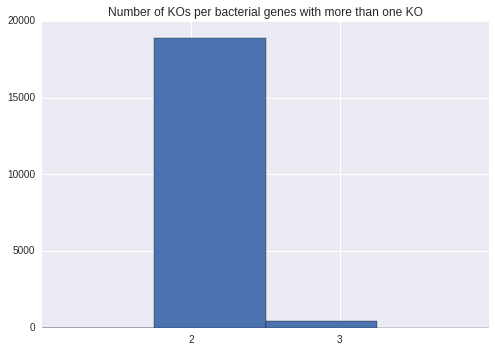

Number of genes that pass filter and have more than one KO: 911
Fraction of those genes out of pass filter genes: 0.0469732907085


In [189]:
one = 0
more_t_one = 0
more_t_one_total = 0
more_t_one_total_l = []
zero = 0
mto_genes = []
one_ko_genes = []
for gene in kegg.get_dicts()['KEGG_COG']:
    if (kegg.get_dicts()['KEGG_COG'][gene]['KEGG'] != 'unknown'):
        kos = kegg.dicts['KEGG_COG'][gene]['KEGG'].split(';')
        if len(kos) > 1:
            mto_genes.append(gene)
            more_t_one += 1.
            more_t_one_total += len(kos)
            more_t_one_total_l.append(len(kos))
        elif len(kos) == 1:
            one_ko_genes.append(gene)
            one += 1
        else:
            zero += 1
print "Number of bacterial genes with one KO: " + str(one)
print "Number of bacterial genes with more than one KO: " + str(more_t_one)
print "Average number of KOs per bacterial genes that have more than one KO: " + str(more_t_one_total/more_t_one)
print "Number of bacterial genes with no KO: " + str(zero)
plt.clf()
plt.hist(more_t_one_total_l, bins=4, range=(1,4))
plt.xticks((2,3))
plt.title("Number of KOs per bacterial genes with more than one KO")
plt.show()
with open('EM_Genes_333210.txt', 'r') as handle:
    g = handle.readlines()
gg = [f.split('\n')[0] for f in g]
gs = set(gg)
mto_genes_s = set(mto_genes)
inters = set.intersection(gs, mto_genes_s)
print "Number of genes that pass filter and have more than one KO: " + str(len(inters))
print  "Fraction of those genes out of pass filter genes: " + str(float(len(inters))/ len(mto_genes_s))

with open('Genes_with_one_KO.txt', 'w') as handle:
    for gene in one_ko_genes:
        handle.write(gene + '\n')

## Generate files with metabolites and KOs for shuffled analysis

In [ ]:
with open('EMGenes_temp_corr_files/GSEA_10000.df', 'rb') as handle:
    gsea_by_ko_10000 = pickle.load(handle)
# plt.hist(gsea_by_ko[gsea_by_ko.test_pval < 0.1].test_pval, bins=50)
# plt.show()
# comps = gsea_by_ko_10000[gsea_by_ko_10000.test_pval < 0.001].CompID.unique()
# np.savetxt('EMGenes_temp_corr_files/metabs_0.001.txt', comps, delimiter='\n', )
gsea_by_ko_10000[gsea_by_ko_10000.test_pval < 1e-3].sort_values(['test_pval']).head(100)
comps  = np.array(gsea_by_ko_10000[gsea_by_ko_10000.test_pval < 1e-3].CompID.unique())
np.savetxt('EMGenes_temp_corr_files/metabs10000_0.001.txt', comps, delimiter='\n')
kos = list(gsea_by_ko_10000[gsea_by_ko_10000.test_pval < 1e-3].KEGG_db_ID.unique())
with open('EMGenes_temp_corr_files/kos10000_0.001.txt', 'w') as handle:
    for k in kos:
        handle.write(k + '\n')
gbk = gsea_by_ko_10000[gsea_by_ko_10000.test_pval < 0.001]
with open('EMGenes_temp_corr_files/metabs_kos_10000_0.001.txt', 'w') as handle:
    for i in range(gbk.shape[0]):
        handle.write(str(gbk.iloc[i,:].CompID) + '\t' + gbk.iloc[i,:].KEGG_db_ID + '\n')

## Last analysis - with shuffled tests and KO filtered 5,10000

In [23]:
with open('EMGenes_shuffled_analysis/GSEA', 'rb') as handle:
    gsea_s = pickle.load(handle)
    gsea_s = gsea_s.drop_duplicates()
with open('EMGenes_temp_corr_files/GSEA_10000.df', 'rb') as handle:
    gsea = pickle.load(handle)

qs = fdr_correction(gsea.test_pval)
qs = qs[1]
gsea['q_value'] = qs
gsea_10000 = gsea[gsea.test_pval < 1e-3]

new_gsea = gsea_10000.copy()
new_col = []
for i in range(new_gsea.shape[0]):
    if i % 5 == 0:
        print i
    l = gsea_10000.iloc[i,:]
    kid = l.KEGGID
    kdbid = l.KEGG_db_ID
    pval = l.test_pval
    
    pvals = np.array(gsea_s[gsea_s.KEGGID == kid][gsea_s.KEGG_db_ID == kdbid].test_pval)
    new_col.append((pvals > pval).sum()/float(len(pvals)))
    
new_gsea['compare_to_shuffeled'] = new_col

new_gsea_copy = new_gsea.copy()
metabs_df = metabs.copy()
new_cols = new_gsea_copy.columns.values
new_cols[0] = 'COMP_ID'
new_gsea_copy.columns = new_cols
imp_cols = ['COMP_ID', 'BIOCHEMICAL', 'SUPER_PATHWAY', 'SUB_PATHWAY', 'MASS']
merged_df = pd.merge(new_gsea_copy, metabs_df.reset_index('COMP_ID', drop=False)[imp_cols], on='COMP_ID').sort_values(['test_pval'])
merged_df.head()

# merged_df.to_csv('EMGenes_shuffled_analysis/GSEA.csv')

0
5


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


10
15
20
25
30
35
40
45
50
55
60


,COMP_ID,KEGGID,KEGG_db_type,KEGG_db_ID,n_genes_in_kegg,n_genes_in_test,n_genes_rest,test_pval,test_statistic,stat_test,downstream_cols,GSEA_ID,q_value,compare_to_shuffeled,BIOCHEMICAL,SUPER_PATHWAY,SUB_PATHWAY,MASS
26,48152,C00031,ko,ko:K05349,8253,715,332495,2.436952e-10,102877928.5,mannwhitney,bac_genes,0,0.000003,0.999005,glucose,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",225.062
38,527,C00186,ko,ko:K00244,4186,166,333044,6.643851e-10,20129460.5,mannwhitney,bac_genes,0,0.000004,0.985075,lactate,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",89.0244
33,12110,C00311,ko,ko:K00244,4186,166,333044,3.011159e-08,20929539.5,mannwhitney,bac_genes,0,0.000128,0.964179,isocitrate,Energy,TCA Cycle,210.061
55,48990,C00022,ko,ko:K00244,4186,166,333044,1.153579e-07,21233618.5,mannwhitney,bac_genes,0,0.000368,0.945274,pyruvate,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",87.0088
27,57,C00025,ko,ko:K00244,4186,166,333044,5.651309e-07,21611799.0,mannwhitney,bac_genes,0,0.001443,0.917413,glutamate,Amino Acid,Glutamate Metabolism,148.06


## Histograms

number of compounds: 194
number of KOs: 919


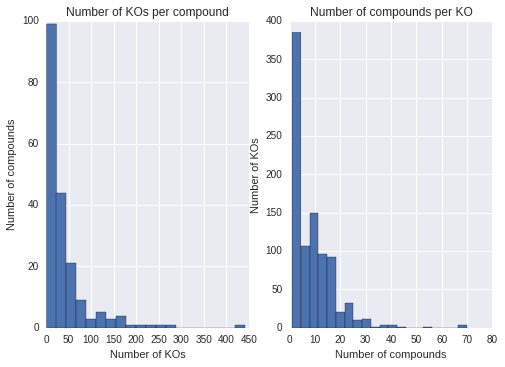

In [710]:
plt.clf()
with open('Grouping_by_ko_5_100000_0.5/Grouped_analysis/GSEA', 'rb') as handle:
    gsea_10000 = pickle.load(handle)
print "number of compounds: " + str(len(gsea_10000.CompID.unique()))
print "number of KOs: " + str(len(gsea_10000.KEGG_db_ID.unique()))

plt.subplot(1,2,1)
plt.hist(gsea_10000.CompID.value_counts(), bins=20)
plt.title("Number of KOs per compound")
plt.xlabel("Number of KOs")
plt.ylabel("Number of compounds")
# plt.show()
plt.subplot(1,2,2)
plt.hist(gsea_10000.KEGG_db_ID.value_counts(), bins=20)
plt.title("Number of compounds per KO")
plt.xlabel("Number of compounds")
plt.ylabel("Number of KOs")
plt.savefig('EMGenes_temp_corr_files/Histograms_compounds-kos.png', bbox_inches='tight')
plt.show()

## Q-Q plot

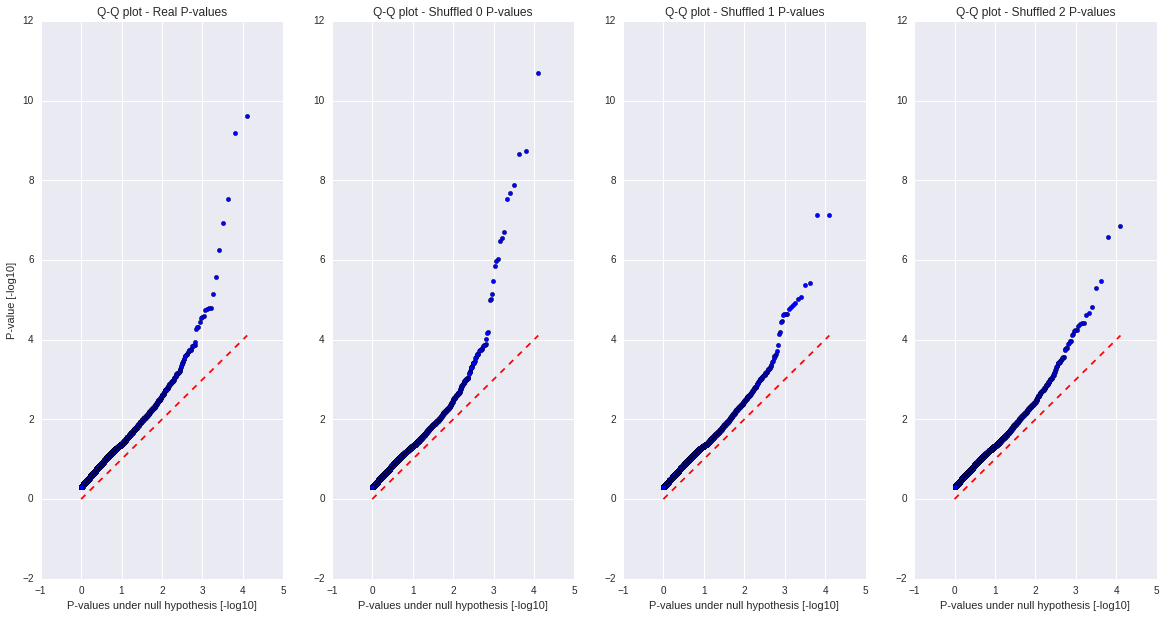

In [115]:
plt.clf()
with open('EMGenes_temp_corr_files/GSEA_10000.df', 'rb') as handle:
    gsea = pickle.load(handle)
xs =np.log10(np.array(range(1,1+gsea.shape[0]))/float(gsea.shape[0]))
pvals = np.log10(gsea.sort_values(['test_pval']).test_pval)
plt.subplot(1, 2, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - GSEA P-values')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')
plt.subplot(1, 2, 2)
plt.scatter(-xs[0:100], -pvals[0:100])
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - first 100 values')
xmin = min(min(-xs[0:100]), min(-pvals[0:100]))
plt.plot([xmin, xmax], [xmin, xmax], '--', color='red')
plt.savefig('EMGenes_shuffled_analysis/Q-Q_plot.png', bbox_inches='tight')

plt.clf()
plt.figure(figsize=(20,10))
with open('EMGenes_all_shuffled_analysis/GSEA', 'rb') as handle:
    gsea_shuffled_all = pickle.load(handle)

s_uniq_vals = gsea_shuffled_all.GSEA_ID.unique()
ns = len(s_uniq_vals)

xs =np.log10(np.array(range(1,1+gsea.shape[0]))/float(gsea.shape[0]))
pvals = np.log10(gsea.sort_values(['test_pval']).test_pval)
ax1 = plt.subplot(1, ns+1, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - Real P-values')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')

for i in range(ns):
    temp_gsea = gsea_shuffled_all[gsea_shuffled_all.GSEA_ID == s_uniq_vals[i]]
    xs =np.log10(np.array(range(1,1+temp_gsea.shape[0]))/float(temp_gsea.shape[0]))
    pvals = np.log10(temp_gsea.sort_values(['test_pval']).test_pval)
    plt.subplot(1, ns+1, i+2, sharey=ax1)
    plt.scatter(-xs, -pvals)
#     plt.ylabel('P-value [-log10]')
    plt.xlabel('P-values under null hypothesis [-log10]')
    plt.title('Q-Q plot - Shuffled ' + str(i) + ' P-values')
    xmax = min(max(-xs), max(-pvals))
    plt.plot([0, xmax], [0, xmax], '--', color='red')
#     plt.setp(ax1.get_yticklabels(), visible=False)
plt.savefig('EMGenes_all_shuffled_analysis/Q-Q_plot_real_vs_shuffle.png', bbox_inches='tight')
plt.show()

plt.clf()

## Group correlate compounds

In [591]:
with open('tmp_files/ppmt_483x1238.df', 'rb') as handle:
    ppmet = Utils.Load(handle)

In [256]:
sethandlers()
with qp('grping', delay_sec=1, tryrerun=True, mem_def='1G', trds_def=2, q = ['himem7.q']) as q:
    q.startpermanentrun()
    ex_grps = semi_exahustive_strict_cor_grouping(ppmet, .75, True, 300, 250, 30, 1, 'spearman', q)

0
1
2
2017-10-02 12:37:21,173 - qp - INFO - Sending to queue (mem 1G, threads 2): python2.7 -W ignore /home/noamba/workspace/lib/queue/qworker.py grping_06a04e694a8f4fa49557d0f5eaa6f324/0.dat;
2017-10-02 12:37:21,312 - qp - INFO - Sending to queue (mem 1G, threads 2): python2.7 -W ignore /home/noamba/workspace/lib/queue/qworker.py grping_06a04e694a8f4fa49557d0f5eaa6f324/1.dat;
2017-10-02 12:37:21,471 - qp - INFO - Sending to queue (mem 1G, threads 2): python2.7 -W ignore /home/noamba/workspace/lib/queue/qworker.py grping_06a04e694a8f4fa49557d0f5eaa6f324/2.dat;
2017-10-02 12:37:21,642 - qp - INFO - Sending to queue (mem 1G, threads 2): python2.7 -W ignore /home/noamba/workspace/lib/queue/qworker.py grping_06a04e694a8f4fa49557d0f5eaa6f324/3.dat;
2017-10-02 12:37:21,784 - qp - INFO - Sending to queue (mem 1G, threads 2): python2.7 -W ignore /home/noamba/workspace/lib/queue/qworker.py grping_06a04e694a8f4fa49557d0f5eaa6f324/4.dat;
2017-10-02 12:37:46,883 - qp - INFO - Sending to queue (mem

In [259]:
to_pickle(ex_grps, 'tmp_files/ex_grps.dat')

In [621]:
cormet = ppmet.corr('spearman', 250)
def select_rep(grp):
    grp_nnl = ppmet[grp].notnull().sum()
    return cormet.loc[grp_nnl[grp_nnl == grp_nnl.max()].index, grp_nnl[grp_nnl == grp_nnl.max()].index].sum(1).argmax()
met_lg = concat((ppmet[select_rep(grp)] for grp in ex_grps), axis = 1)

In [266]:
to_pickle(met_lg, 'tmp_files/ppmet_483x820.df')

In [1127]:
met_lg = Utils.Load('tmp_files/ppmet_483x820.df')
met_gr_rel = met_lg.loc[:,metabs_to_use].dropna(how='all', axis=1)
Utils.Write('tmp_files/ppmet_grouped_and_reliable_483x759.df', met_gr_rel)

### emphasis on keeping compounds with info

In [663]:
ex_grps = Utils.Load('tmp_files/ex_grps.dat')
ex_grps_names = []
for e in ex_grps:
    has_names = False
    temp_ent = []
    for m in e:
        if not re.match('^X - ', metabs.loc[m].BIOCHEMICAL):
            temp_ent.append(m)
            has_names = True
    if not has_names:
        temp_ent = e
    ex_grps_names.append(temp_ent)
    
cormet = ppmet.corr('spearman', 250)
def select_rep(grp):
    grp_nnl = ppmet[grp].notnull().sum()
    return cormet.loc[grp_nnl[grp_nnl == grp_nnl.max()].index, grp_nnl[grp_nnl == grp_nnl.max()].index].sum(1).argmax()
met_lg_names = concat((ppmet[select_rep(grp)] for grp in ex_grps_names), axis = 1)

to_pickle(met_lg_names, 'tmp_files/ppmet_483x820_names.df')

print set(metabs.loc[met_lg.columns].BIOCHEMICAL.values) - set(metabs.loc[met_lg_names.columns].BIOCHEMICAL.values) 
print set(metabs.loc[met_lg_names.columns].BIOCHEMICAL.values) - set(metabs.loc[met_lg.columns].BIOCHEMICAL.values) 

set([u'X - 12230', u'X - 22764', u'X - 11440', u'X - 22379'])
set([u'3-hydroxylaurate', u'pregnen-diol disulfate C21H34O8S2*', u'androstenediol (3alpha, 17alpha) monosulfate (2)', u'2,3-dihydroxypyridine'])


## Grouped analysis

In [5]:
# grouped_dir = 'Grouping_by_ko_20_100000_0.75/'
grouped_dir = 'Grouping_by_ko_5_100000_0.5/'

In [112]:
with open(grouped_dir + '/Grouped_analysis/GSEA', 'rb') as handle:
    gsea_gr = pickle.load(handle)
comps  = np.array(gsea_gr[gsea_gr.test_pval < 1e-3].CompID.unique())
np.savetxt(grouped_dir + '/Grouped_analysis/metabs_0.001.txt', comps, delimiter='\n')
kos = list(gsea_gr[gsea_gr.test_pval < 1e-3].KEGG_db_ID.unique())
with open(grouped_dir + '/Grouped_analysis/kos_0.001.txt', 'w') as handle:
    for k in kos:
        handle.write(k + '\n')
gbk = gsea_gr[gsea_gr.test_pval < 0.001]
with open(grouped_dir + '/Grouped_analysis/metabs_kos_0.001.txt', 'w') as handle:
    for i in range(gbk.shape[0]):
        handle.write(str(gbk.iloc[i,:].CompID) + '\t' + gbk.iloc[i,:].KEGG_db_ID + '\n')

### q-q plot

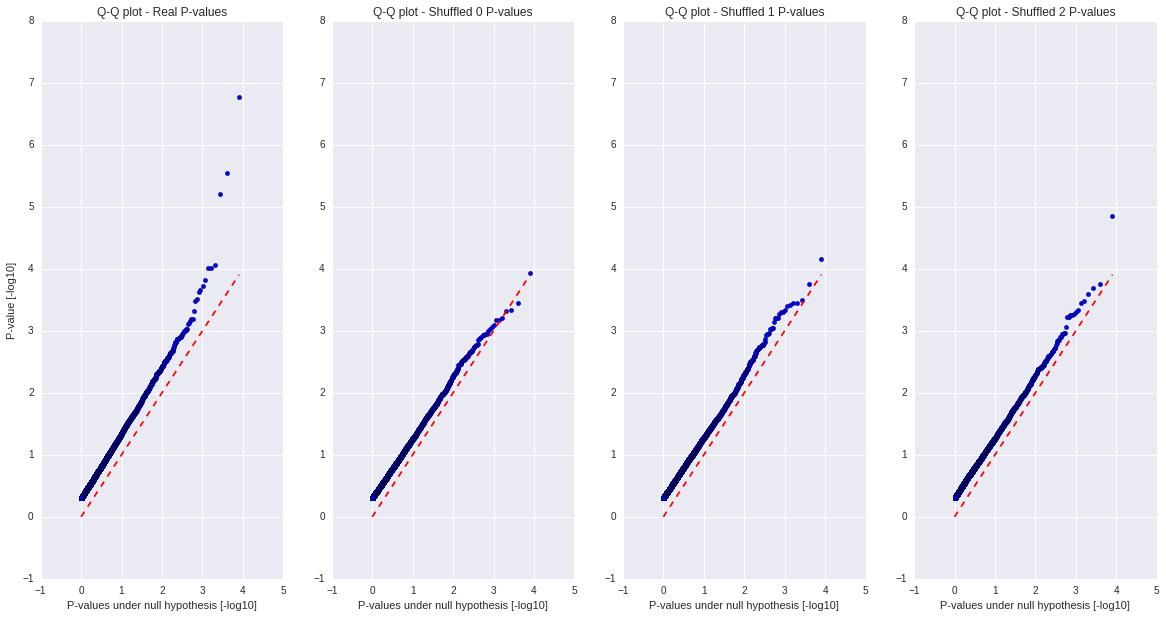

In [133]:
plt.clf()
gsea_gr = Utils.Load(grouped_dir + '/Grouped_analysis/GSEA')
xs =np.log10(np.array(range(1,1+gsea_gr.shape[0]))/float(gsea_gr.shape[0]))
pvals = np.log10(gsea_gr.sort_values(['test_pval']).test_pval)
plt.subplot(1, 2, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - GSEA P-values')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')
plt.subplot(1, 2, 2)
plt.scatter(-xs[0:100], -pvals[0:100])
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - first 100 values')
xmin = min(min(-xs[0:100]), min(-pvals[0:100]))
plt.plot([xmin, xmax], [xmin, xmax], '--', color='red')
plt.savefig(grouped_dir + '/Grouped_analysis/Q-Q_plot.png', bbox_inches='tight')

plt.clf()
plt.figure(figsize=(20,10))
with open(grouped_dir + '/Grouped_all_shuffled_analysis/GSEA', 'rb') as handle:
    gsea_gr_shuffled_all = pickle.load(handle)

s_uniq_vals = gsea_gr_shuffled_all.GSEA_ID.unique()
ns = len(s_uniq_vals)

xs =np.log10(np.array(range(1,1+gsea_gr.shape[0]))/float(gsea_gr.shape[0]))
pvals = np.log10(gsea_gr.sort_values(['test_pval']).test_pval)
ax1 = plt.subplot(1, ns+1, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - Real P-values')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')

for i in range(ns):
    temp_gsea = gsea_gr_shuffled_all[gsea_gr_shuffled_all.GSEA_ID == s_uniq_vals[i]]
    xs =np.log10(np.array(range(1,1+temp_gsea.shape[0]))/float(temp_gsea.shape[0]))
    pvals = np.log10(temp_gsea.sort_values(['test_pval']).test_pval)
    plt.subplot(1, ns+1, i+2, sharey=ax1)
    plt.scatter(-xs, -pvals)
#     plt.ylabel('P-value [-log10]')
    plt.xlabel('P-values under null hypothesis [-log10]')
    plt.title('Q-Q plot - Shuffled ' + str(i) + ' P-values')
    xmax = min(max(-xs), max(-pvals))
    plt.plot([0, xmax], [0, xmax], '--', color='red')
#     plt.setp(ax1.get_yticklabels(), visible=False)
plt.savefig(grouped_dir + '/Grouped_all_shuffled_analysis/Q-Q_plot_real_vs_shuffle.png', bbox_inches='tight')
plt.show()

plt.clf()

### compare to shuffled tests

In [305]:
gsea_gr_s = Utils.Load(grouped_dir + '/Grouped_shuffled_analysis/GSEA')
gsea_gr_s = gsea_gr_s.drop_duplicates()
print gsea_gr_s.shape
gsea_gr = Utils.Load(grouped_dir + '/Grouped_analysis/GSEA')

qs = fdr_correction(gsea_gr.test_pval)
qs = qs[1]
gsea_gr['q_value'] = qs
gsea_gr = gsea_gr[gsea_gr.test_pval < 1e-3]

col_names = ['CompID', 'KEGG_db_ID']
gsea_gr = pd.merge(gsea_gr, gsea_gr_s[col_names].drop_duplicates(), how='inner', on=col_names)

new_gsea = gsea_gr.copy()
new_col = []
for i in range(new_gsea.shape[0]):
    if i % 5 == 0:
        print i
    l = gsea_gr.iloc[i,:]
    kid = l.KEGGID
    kdbid = l.KEGG_db_ID
    pval = l.test_pval
    temp_df = gsea_gr_s[gsea_gr_s.KEGGID == kid]
    temp_df = temp_df[temp_df.KEGG_db_ID == kdbid]
    pvals = np.array(temp_df.test_pval)
    new_col.append(1 - (pvals > pval).sum()/float(len(pvals)))
    
new_gsea['Corrected_p-value_by_shuffled_tests)'] = new_col
new_gsea['num_of_shuffled_tests'] = temp_df.shape[0]

new_gsea_copy = new_gsea.copy()
metabs_df = metabs.copy()
new_cols = new_gsea_copy.columns.values
new_cols[0] = 'COMP_ID'
new_gsea_copy.columns = new_cols
imp_cols = ['COMP_ID', 'BIOCHEMICAL', 'SUPER_PATHWAY', 'SUB_PATHWAY', 'MASS']
merged_df = pd.merge(new_gsea_copy, metabs_df.reset_index('COMP_ID', drop=False)[imp_cols], on='COMP_ID').sort_values(['test_pval'])
Utils.Write(grouped_dir + '/Grouped_shuffled_analysis/GSEA_compared.df', merged_df)
merged_df.to_csv(grouped_dir + '/Grouped_shuffled_analysis/GSEA_compared.csv')

(100000, 12)
0
9.83584672661e-05
(20000, 12)
0.00025
0.000307847398084
(20000, 12)
0.00025
6.29810365512e-06
(20000, 12)
5e-05
9.69435744287e-05
(20000, 12)
0.00025
0.000785773775689
(20000, 12)
0.00045


In [101]:
gsea_next_step = Utils.Load(grouped_dir + '/Grouped_shuffled_analysis/GSEA_compared.df')
gsea_next_step = gsea_next_step[gsea_next_step.compare_to_shuffeled >= 0.999]
gsea_next_step_9995 = gsea_next_step[gsea_next_step.compare_to_shuffeled >= 0.9995]

# np.savetxt(grouped_dir + '/Grouped_analysis/metabs_0.999.txt', gsea_next_step.COMP_ID.unique(), delimiter='\n')
# with open(grouped_dir + '/Grouped_analysis/metabs_kos_0.999.txt', 'w') as handle:
#     for i in range(gsea_next_step.shape[0]):
#         handle.write(str(gsea_next_step.iloc[i,:].COMP_ID) + '\t' + gsea_next_step.iloc[i,:].KEGG_db_ID + '\n')
np.savetxt(grouped_dir + '/Grouped_analysis/metabs_0.9995.txt', gsea_next_step_9995.COMP_ID.unique(), delimiter='\n')
with open(grouped_dir + '/Grouped_analysis/metabs_kos_0.9995.txt', 'w') as handle:
    for i in range(gsea_next_step_9995.shape[0]):
        handle.write(str(gsea_next_step_9995.iloc[i,:].COMP_ID) + '\t' + gsea_next_step_9995.iloc[i,:].KEGG_db_ID + '\n')

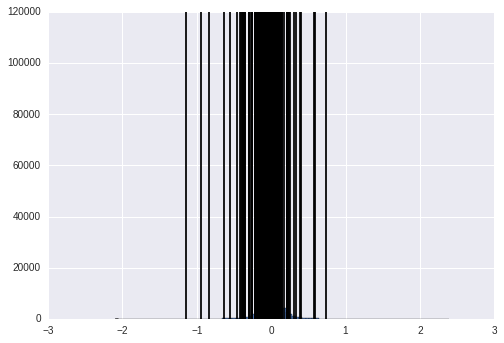

In [129]:
plt.clf()
genes = kegg.get_dicts()['ko_bacgene']['ko:K05349']
plt.hist(EMGenes_pvals.loc[48152].dropna(), bins=100)
xcoords =EMGenes_pvals.loc[48152][genes].dropna()
for xc in xcoords:
    plt.axvline(x=xc, color='black')
plt.show()

## Mantel test 

### EMGenes preperation

In [1129]:
print datetime.now()
EMGenes_mat = Utils.Load('Grouping_by_ko_5_100000_0.5/EMGenes_group.df')
print datetime.now()
EMGenes_mat_no_log10= EMGenes_mat.apply(lambda x: 10**x)
print datetime.now()
EMGenes_mat_no_log10_no_null = EMGenes_mat_no_log10.fillna(0)
print datetime.now()

2017-11-28 12:19:21.070667
2017-11-28 12:19:36.156631
2017-11-28 12:21:06.053222
2017-11-28 12:21:10.490810


In [1133]:
dis_mat_dir = 'Grouping_by_ko_5_100000_0.5/distance_matrices'
if not os.path.exists(dis_mat_dir): os.makedirs(dis_mat_dir)

#### Bray-Curtis

In [1134]:
EMGenes_BC_res = compute_distance_matrix(EMGenes_mat_no_log10_no_null, BrayCurtis, do_binary=False)  
Utils.Write(dis_mat_dir + '/EMGenes_BC_res.df', EMGenes_BC_res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Binazrized-Euclidean

In [1137]:
EMGenes_BinEuc_res = compute_distance_matrix(EMGenes_mat_no_log10_no_null, pdist, do_binary=True)  
Utils.Write(dis_mat_dir + '/EMGenes_BinEuc_res.df', EMGenes_BinEuc_res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1139]:
EMGenes_BC_res = Utils.Load(dis_mat_dir + '/EMGenes_BC_res.df')
EMGenes_BinEuc_res = Utils.Load(dis_mat_dir + '/EMGenes_BinEuc_res.df')

### Metabolites preperation

In [1148]:
metabolites_mat = Utils.Load('tmp_files/ppmet_483x820.df')
metabolites_mat_reliable = Utils.Load('tmp_files/ppmet_grouped_and_reliable_483x759.df')
metabolites_mat_no_na = metabolites_mat.fillna(-5)
metabolites_mat_reliable_no_na = metabolites_mat_reliable.fillna(-5)
metabs_dic = {'metabolites_all':metabolites_mat, 'metabolites_all_no_na':metabolites_mat_no_na,
                          'metabolites_reliable':metabolites_mat_reliable, 'metabolites_reliable_no_na':metabolites_mat_reliable_no_na}

#### Euclidean

In [1151]:
for met in metabs_dic:
    temp_met_res = compute_distance_matrix(metabs_dic[met], pdist, do_binary=False)
    Utils.Write(dis_mat_dir + '/' + met + '_Euc.df', temp_met_res)

metabolites_reliable_no_na
metabolites_all
metabolites_reliable
metabolites_all_no_na


### Izhak DIAMOND KOs method

In [1763]:
# diamond_kos = Utils.Load('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Me_DF_KOs_DIAMOND_threshold_0.1')
diamond_kos = Utils.Load('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Me_DF_KOs_DIAMOND_threshold_0.001')
diamond_kos = diamond_kos.loc[metabolon_fd_cid.FD_CID]
assert diamond_kos.shape[0] == metabolon_fd_cid.FD_CID.shape[0]

In [1764]:
diamond_kos.index.names = ['FD_CID']
diamond_kos.reset_index(inplace=True)
diamond_kos = pd.merge(diamond_kos, metabolon_fd_cid[['SID_', 'FD_CID']], on = ['FD_CID'])
diamond_kos.set_index('SID_', inplace=True)
diamond_kos.index.names = ['CLIENT_IDENTIFIER']
del diamond_kos['FD_CID']
diamond_kos.head()

,K01369,K01365,K01364,K01366,K01361,K01363,K01362,K08568,K05849,K05841,...,K05903,K10188,K05908,K00368,K00369,K00366,K00364,K00362,K00363,K00360
CLIENT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,
Sid_1,1.240127e-06,1.807192e-07,0.000034,0.0,0.000034,0.0,0.002053,0.0,0.0,0.000014,...,0.000025,0.000181,0.0,1.768678e-07,1.254814e-07,0.000053,0.000016,0.000021,3.658941e-06,0.0
Sid_29,1.702764e-07,0.000000e+00,0.000003,0.0,0.000321,0.0,0.001879,0.0,0.0,0.000012,...,0.000016,0.000435,0.0,2.039934e-06,3.618152e-07,0.000039,0.000010,0.000034,5.861250e-07,0.0
Sid_3,1.606270e-06,0.000000e+00,0.000038,0.0,0.000023,0.0,0.002032,0.0,0.0,0.000015,...,0.000020,0.000191,0.0,0.000000e+00,8.848816e-07,0.000043,0.000012,0.000016,1.843033e-06,0.0
Sid_31,1.394084e-06,0.000000e+00,0.000108,0.0,0.000054,0.0,0.002084,0.0,0.0,0.000005,...,0.000026,0.000495,0.0,1.739720e-07,0.000000e+00,0.000040,0.000011,0.000020,5.998392e-07,0.0
Sid_61,3.460574e-06,1.857935e-07,0.000017,0.0,0.000105,0.0,0.002141,0.0,0.0,0.000022,...,0.000015,0.000271,0.0,3.273011e-06,3.870142e-07,0.000125,0.000011,0.000019,1.253893e-06,0.0


In [1698]:
diamonds_corr = diamond_kos.corr('spearman')

In [1893]:
# permute each KO
diamond_kos_permuted = diamond_kos.apply(lambda x: np.random.permutation(x))
diamonds_permuted_corr = diamond_kos_permuted.corr('spearman')

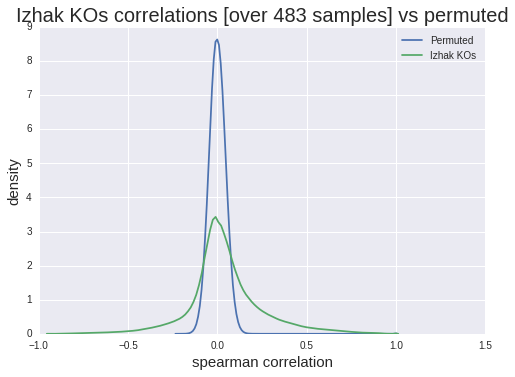

In [1894]:
sns.distplot(diamonds_permuted_corr.stack(), hist=False, label='Permuted')
sns.distplot(diamonds_corr.stack(), hist=False, label='Izhak KOs')
plt.title('Izhak KOs correlations [over 483 samples] vs permuted', fontsize=20)
plt.xlabel('spearman correlation', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.show()

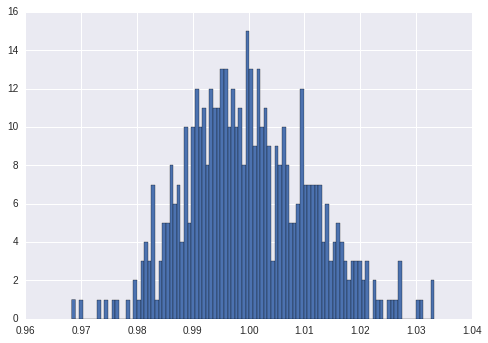

In [1891]:
plt.hist(diamond_kos_permuted.sum(1), bins=100)
plt.show()

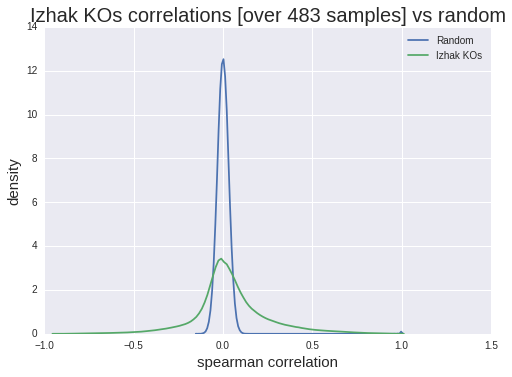

In [1754]:
x10000 = [random.uniform(0,1) for i in range(1000000)]
rand_mat = np.array(x10000)
rand_mat = rand_mat.reshape((1000,1000))
rand_df = pd.DataFrame(rand_mat, index=range(1000,2000))
rand_df = rand_df.apply(lambda x: x/x.sum())
rand_corr = rand_df.corr('spearman')
sns.distplot(rand_corr.stack(), hist=False, label='Random')
sns.distplot(diamonds_corr.stack(), hist=False, label='Izhak KOs')
plt.title('Izhak KOs correlations [over 483 samples] vs random', fontsize=20)
plt.xlabel('spearman correlation', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.show()

In [1758]:
KO_DIAMOND_Euc_res = compute_distance_matrix(diamond_kos, pdist, do_binary=False)
Utils.Write(dis_mat_dir + '/KO_DIAMOND_Euc_res0.001.df', KO_DIAMOND_Euc_res)
# # Utils.Write(dis_mat_dir + '/KO_DIAMOND_Euc_res.df', KO_DIAMOND_Euc_res)

KO_DIAMOND_BinEuc_res = compute_distance_matrix(diamond_kos, pdist, do_binary=True)
Utils.Write(dis_mat_dir + '/KO_DIAMOND_BinEuc_res0.001.df', KO_DIAMOND_BinEuc_res)
# # Utils.Write(dis_mat_dir + '/KO_DIAMOND_BinEuc_res.df', KO_DIAMOND_BinEuc_res)

KO_DIAMOND_BC_res = compute_distance_matrix(diamond_kos, BrayCurtis, do_binary=False)
Utils.Write(dis_mat_dir + '/KO_DIAMOND_BC_res0.001.df', KO_DIAMOND_BC_res)
# Utils.Write(dis_mat_dir + '/KO_DIAMOND_BinEuc_res.df', KO_DIAMOND_BinEuc_res)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480


In [1580]:
KO_DIAMOND_Euc_res = Utils.Load(dis_mat_dir + '/KO_DIAMOND_Euc_res0.001.df')
KO_DIAMOND_BinEuc_res = Utils.Load(dis_mat_dir + '/KO_DIAMOND_BinEuc_res0.001.df')
KO_DIAMOND_BC_res = Utils.Load(dis_mat_dir + '/KO_DIAMOND_BC_res0.001.df')

### Running the Mantel test

#### over all metabolites

In [1767]:
met_dist = Utils.Load('Grouping_by_ko_5_100000_0.5/distance_matrices/metabolites_reliable_Euc.df')
met_dist_no_na = Utils.Load('Grouping_by_ko_5_100000_0.5/distance_matrices/metabolites_reliable_no_na_Euc.df')

##### spearman

In [1768]:
print "Mantel test for EMGenes (Bray-Curtis) and Metabolites (Euclidean): "
print mantel_test(met_dist, EMGenes_BC_res, perms=1000, method='spearman', tail='upper')
print "Mantel test for EMGenes (Euclidian) and Metabolites (Euclidean): "
print mantel_test(met_dist, EMGenes_BinEuc_res, perms=1000, method='spearman', tail='upper')
print "Mantel test for EMGenes (Euclidian) and Metabolites with no na (Euclidean): "
print mantel_test(met_dist_no_na, EMGenes_BinEuc_res, perms=1000, method='spearman', tail='upper')

Mantel test for EMGenes (Bray-Curtis) and Metabolites (Euclidean): 
1
(0.037604655868678817, 0.058999999999999997, 1.6168105094553653)
Mantel test for EMGenes (Euclidian) and Metabolites (Euclidean): 
1
(0.039594893195076586, 0.021000000000000001, 1.9257315531228751)
Mantel test for EMGenes (Euclidian) and Metabolites with no na (Euclidean): 
1
(0.032352904495673324, 0.057000000000000002, 1.6087886864756058)


##### pearson

In [1769]:
print "Mantel test for EMGenes (Bray-Curtis) and Metabolites (Euclidean): "
print mantel_test(met_dist, EMGenes_BC_res, perms=1000, method='pearson', tail='upper')
print "Mantel test for EMGenes (Euclidian) and Metabolites (Euclidean): "
print mantel_test(met_dist, EMGenes_BinEuc_res, perms=1000, method='pearson', tail='upper')
print "Mantel test for EMGenes (Euclidian) and Metabolites with no na (Euclidean): "
print mantel_test(met_dist_no_na, EMGenes_BinEuc_res, perms=1000, method='pearson', tail='upper')

Mantel test for EMGenes (Bray-Curtis) and Metabolites (Euclidean): 
1
(0.038520166814092843, 0.058000000000000003, 1.584577413356822)
Mantel test for EMGenes (Euclidian) and Metabolites (Euclidean): 
1
(0.049305504243629686, 0.0089999999999999993, 2.3168561793837572)
Mantel test for EMGenes (Euclidian) and Metabolites with no na (Euclidean): 
1
(0.039831966406949713, 0.029999999999999999, 1.9127878458930669)


In [1770]:
print "Mantel test for Izhak KO (Binary-Euclidian) and Metabolites (Euclidean): "
print mantel_test(met_dist, KO_DIAMOND_BinEuc_res, perms=1000, method='pearson', tail='upper')
print "Mantel test for Izhak KO (Euclidian) and Metabolites (Euclidean): "
print mantel_test(met_dist, KO_DIAMOND_Euc_res, perms=1000, method='pearson', tail='upper')
print "Mantel test for Izhak KO (Bray-Curtis) and Metabolites (Euclidean): "
print mantel_test(met_dist, KO_DIAMOND_BC_res, perms=1000, method='pearson', tail='upper')

Mantel test for Izhak KO (Binary-Euclidian) and Metabolites (Euclidean): 
1
(0.0077897472882176499, 0.35799999999999998, 0.33223428193509064)
Mantel test for Izhak KO (Euclidian) and Metabolites (Euclidean): 
1
(0.020485854793955666, 0.25700000000000001, 0.6562973165235515)
Mantel test for Izhak KO (Bray-Curtis) and Metabolites (Euclidean): 
1
(0.013455468168327664, 0.317, 0.486655074510425)


#### Mantel for each metabolite

In [1863]:
dist_mat_by_metabolite_not_null = {}
for i in range(metabolites_mat.shape[1]):
#     temp_met = metabolites_mat_na_median.iloc[:,i]
#     temp_subects = temp_met.index
#     temp_met = temp_met.values
#     temp_met = np.reshape(temp_met, (temp_met.shape[0], 1))
#     dist_mat_by_metabolite_median_null[metabolites_mat.columns[i]] = (cdist(temp_met, temp_met), temp_subects)
    temp_met = metabolites_mat.iloc[:,i].dropna()
    temp_subects = temp_met.index
    temp_met = temp_met.values
    temp_met = np.reshape(temp_met, (temp_met.shape[0], 1))
    dist_mat_by_metabolite_not_null[metabolites_mat.columns[i]] = (cdist(temp_met, temp_met), temp_subects)

In [1592]:
dist_mat_by_metabolite_not_null = {}
for i in range(metabolites_mat_reliable.shape[1]):
    temp_met = metabolites_mat_reliable.iloc[:,i].dropna()
    temp_subects = temp_met.index
    temp_met = temp_met.values
    temp_met = np.reshape(temp_met, (temp_met.shape[0], 1))
    dist_mat_by_metabolite_not_null[metabolites_mat_reliable.columns[i]] = (cdist(temp_met, temp_met), temp_subects)

In [1865]:
distance_dict = {'EMGenes_BC_res':EMGenes_BC_res, 'EMGenes_BinEuc_res':EMGenes_BinEuc_res,
                                'KO_DIAMOND_BC_res':KO_DIAMOND_BC_res, 'KO_DIAMOND_BinEuc_res':KO_DIAMOND_BinEuc_res, 
                                 'KO_DIAMOND_Euc_res':KO_DIAMOND_Euc_res}

##### two for loops running Mantel test over all metabolites

In [1882]:
for permute in [True, False]:
    for temp_distance in distance_dict:
        mental_per_met_new = pd.DataFrame(0, index=dist_mat_by_metabolite_not_null.keys() ,columns=['COMP_ID', 'dist_matrix_size', 'cor_method', 'num_permutations', 'tail','correlation', 'empirical_p_val', 'z_score', 'EMGenes_file', 'EMGenes_distance'])

        distance_mat = distance_dict[temp_distance].copy()
        EMGenes_distance = temp_distance
        if permute:
            print "permute"
            print temp_distance
            EMGenes_distance = EMGenes_distance + '_permuted'
            perm_order = np.random.permutation(distance_mat.index)
            distance_mat.index = perm_order
            distance_mat.columns = perm_order
        cor_method = 'pearson'
        # cor_method = 'spearman'
        num_permutations = 100
        max_num_permutations = 1000000
        tail = 'upper'
        EMGenes_file = 'Grouping_by_ko_5_100000_0.5/EMGenes_group.df'

        metabs_remain = dist_mat_by_metabolite_not_null.keys()
        while len(metabs_remain) > 0 and num_permutations <= max_num_permutations:
            print num_permutations
            print len(metabs_remain)
            print datetime.now()
            c = 0
            for m in metabs_remain:
                print c; c+=1
                pos = dist_mat_by_metabolite_not_null[m][1]
                temp_EM = distance_mat.loc[pos, pos]
                r, p, z = mantel_test(dist_mat_by_metabolite_not_null[m][0], temp_EM.values, num_permutations, method=cor_method, tail=tail)
                mental_per_met_new.loc[m] = [m, len(pos), cor_method, num_permutations, tail, r, p, z, EMGenes_file, EMGenes_distance]
            metabs_remain = mental_per_met_new[mental_per_met_new.empirical_p_val <= 10./num_permutations].COMP_ID
            num_permutations = num_permutations * 10

        q = fdr_correction(mental_per_met_new.empirical_p_val)
        q = q[1]
        mental_per_met_new['q_value'] = q
        metabs_df = metabs.copy()
        imp_cols = ['COMP_ID', 'BIOCHEMICAL', 'SUPER_PATHWAY', 'SUB_PATHWAY']
        mental_per_met_new = pd.merge(mental_per_met_new, metabs_df.reset_index('COMP_ID', drop=False)[imp_cols], on='COMP_ID').sort_values(['empirical_p_val'])
        mental_per_met_new = pd.merge(mental_per_met_new, normed_cv_df.reset_index('COMP_ID', drop=False), on='COMP_ID').sort_values(['empirical_p_val'])
        Utils.Write('Grouping_by_ko_5_100000_0.5/Mantel/Mantel_per_metabolite_' + EMGenes_distance + '_' + cor_method + '.df', mental_per_met_new)
        mental_per_met_new.to_csv('Grouping_by_ko_5_100000_0.5/Mantel/Mantel_per_metabolite_' + EMGenes_distance + '_' + cor_method + '.csv')

permute
KO_DIAMOND_BinEuc_res
100
820
2017-12-01 14:34:55.286968
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1
80
1
81
1
82
1
83
1
84
1
85
1
86
1
87
1
88
1
89
1
90
1
91
1
92
1
93
1
94
1
95
1
96
1
97
1
98
1
99
1
100
1
101
1
102
1
103
1
104
1
105
1
106
1
107
1
108
1
109
1
110
1
111
1
112
1
113
1
114
1
115
1
116
1
117
1
118
1
119
1
120
1
121
1
122
1
123
1
124
1
125
1
126
1
127
1
128
1
129
1
130
1
131
1
132
1
133
1
134
1
135
1
136
1
137
1
138
1
139
1
140
1
141
1
142
1
143
1
144
1
145
1
146
1
147
1
148
1
149
1
150
1
151
1
152
1
153
1
154
1
155
1
156
1
157
1
158
1
159
1
160
1
161
1
162
1
163
1
164
1
165
1
166
1
167
1
168
1
169
1
170
1
171
1
172
1
173
1
1

476
1
477
1
478
1
479
1
480
1
481
1
482
1
483
1
484
1
485
1
486
1
487
1
488
1
489
1
490
1
491
1
492
1
493
1
494
1
495
1
496
1
497
1
498
1
499
1
500
1
501
1
502
1
503
1
504
1
505
1
506
1
507
1
508
1
509
1
510
1
511
1
512
1
513
1
514
1
515
1
516
1
517
1
518
1
519
1
520
1
521
1
522
1
523
1
524
1
525
1
526
1
527
1
528
1
529
1
530
1
531
1
532
1
533
1
534
1
535
1
536
1
537
1
538
1
539
1
540
1
541
1
542
1
543
1
544
1
545
1
546
1
547
1
548
1
549
1
550
1
551
1
552
1
553
1
554
1
555
1
556
1
557
1
558
1
559
1
560
1
561
1
562
1
563
1
564
1
565
1
566
1
567
1
568
1
569
1
570
1
571
1
572
1
573
1
574
1
575
1
576
1
577
1
578
1
579
1
580
1
581
1
582
1
583
1
584
1
585
1
586
1
587
1
588
1
589
1
590
1
591
1
592
1
593
1
594
1
595
1
596
1
597
1
598
1
599
1
600
1
601
1
602
1
603
1
604
1
605
1
606
1
607
1
608
1
609
1
610
1
611
1
612
1
613
1
614
1
615
1
616
1
617
1
618
1
619
1
620
1
621
1
622
1
623
1
624
1
625
1
626
1
627
1
628
1
629
1
630
1
631
1
632
1
633
1
634
1
635
1
636
1
637
1
638
1
639
1
640
1
641
1
642


7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1
80
1
81
1
82
1
83
1
84
1
85
1
86
1
87
1
88
1
89
1
90
1
91
1
92
1
93
1
94
1
95
1
96
1
97
1
98
1
99
1
100
1
101
1
102
1
103
1
104
1
105
1
106
1
107
1
108
1
109
1
110
1
111
1
112
1
113
1
114
1
115
1
116
1
117
1
118
1
119
1
120
1
121
1
122
1
123
1
124
1
125
1
126
1
127
1
128
1
129
1
130
1
131
1
132
1
133
1
134
1
135
1
136
1
137
1
138
1
139
1
140
1
141
1
142
1
143
1
144
1
145
1
146
1
147
1
148
1
149
1
150
1
151
1
152
1
153
1
154
1
155
1
156
1
157
1
158
1
159
1
160
1
161
1
162
1
163
1
164
1
165
1
166
1
167
1
168
1
169
1
170
1
171
1
172
1
173
1
174
1
175
1
176
1
177
1
178
1
179
1
180
1
181
1
182
1
183
1
184
1
185
1
186
1
187
1
188
1
189


487
1
488
1
489
1
490
1
491
1
492
1
493
1
494
1
495
1
496
1
497
1
498
1
499
1
500
1
501
1
502
1
503
1
504
1
505
1
506
1
507
1
508
1
509
1
510
1
511
1
512
1
513
1
514
1
515
1
516
1
517
1
518
1
519
1
520
1
521
1
522
1
523
1
524
1
525
1
526
1
527
1
528
1
529
1
530
1
531
1
532
1
533
1
534
1
535
1
536
1
537
1
538
1
539
1
540
1
541
1
542
1
543
1
544
1
545
1
546
1
547
1
548
1
549
1
550
1
551
1
552
1
553
1
554
1
555
1
556
1
557
1
558
1
559
1
560
1
561
1
562
1
563
1
564
1
565
1
566
1
567
1
568
1
569
1
570
1
571
1
572
1
573
1
574
1
575
1
576
1
577
1
578
1
579
1
580
1
581
1
582
1
583
1
584
1
585
1
586
1
587
1
588
1
589
1
590
1
591
1
592
1
593
1
594
1
595
1
596
1
597
1
598
1
599
1
600
1
601
1
602
1
603
1
604
1
605
1
606
1
607
1
608
1
609
1
610
1
611
1
612
1
613
1
614
1
615
1
616
1
617
1
618
1
619
1
620
1
621
1
622
1
623
1
624
1
625
1
626
1
627
1
628
1
629
1
630
1
631
1
632
1
633
1
634
1
635
1
636
1
637
1
638
1
639
1
640
1
641
1
642
1
643
1
644
1
645
1
646
1
647
1
648
1
649
1
650
1
651
1
652
1
653


19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1
80
1
81
1
82
1
83
1
84
1
85
1
86
1
87
1
88
1
89
1
90
1
91
1
92
1
93
1
94
1
95
1
96
1
97
1
98
1
99
1
100
1
101
1
102
1
103
1
104
1
105
1
106
1
107
1
108
1
109
1
110
1
111
1
112
1
113
1
114
1
115
1
116
1
117
1
118
1
119
1
120
1
121
1
122
1
123
1
124
1
125
1
126
1
127
1
128
1
129
1
130
1
131
1
132
1
133
1
134
1
135
1
136
1
137
1
138
1
139
1
140
1
141
1
142
1
143
1
144
1
145
1
146
1
147
1
148
1
149
1
150
1
151
1
152
1
153
1
154
1
155
1
156
1
157
1
158
1
159
1
160
1
161
1
162
1
163
1
164
1
165
1
166
1
167
1
168
1
169
1
170
1
171
1
172
1
173
1
174
1
175
1
176
1
177
1
178
1
179
1
180
1
181
1
182
1
183
1
184
1
185
1
186
1
187
1
188
1
189
1
190
1
191
1
192
1
193
1
194
1
195
1
196
1
197
1
198
1
1

385
1
386
1
387
1
388
1
389
1
390
1
391
1
392
1
393
1
394
1
395
1
396
1
397
1
398
1
399
1
400
1
401
1
402
1
403
1
404
1
405
1
406
1
407
1
408
1
409
1
410
1
411
1
412
1
413
1
414
1
415
1
416
1
417
1
418
1
419
1
420
1
421
1
422
1
423
1
424
1
425
1
426
1
427
1
428
1
429
1
430
1
431
1
432
1
433
1
434
1
435
1
436
1
437
1
438
1
439
1
440
1
441
1
442
1
443
1
444
1
445
1
446
1
447
1
448
1
449
1
450
1
451
1
452
1
453
1
454
1
455
1
456
1
457
1
458
1
459
1
460
1
461
1
462
1
463
1
464
1
465
1
466
1
467
1
468
1
469
1
470
1
471
1
472
1
473
1
474
1
475
1
476
1
477
1
478
1
479
1
480
1
481
1
482
1
483
1
484
1
485
1
486
1
487
1
488
1
489
1
490
1
491
1
492
1
493
1
494
1
495
1
496
1
497
1
498
1
499
1
500
1
501
1
502
1
503
1
504
1
505
1
506
1
507
1
508
1
509
1
510
1
511
1
512
1
513
1
514
1
515
1
516
1
517
1
518
1
519
1
520
1
521
1
522
1
523
1
524
1
525
1
526
1
527
1
528
1
529
1
530
1
531
1
532
1
533
1
534
1
535
1
536
1
537
1
538
1
539
1
540
1
541
1
542
1
543
1
544
1
545
1
546
1
547
1
548
1
549
1
550
1
551


703
1
704
1
705
1
706
1
707
1
708
1
709
1
710
1
711
1
712
1
713
1
714
1
715
1
716
1
717
1
718
1
719
1
720
1
721
1
722
1
723
1
724
1
725
1
726
1
727
1
728
1
729
1
730
1
731
1
732
1
733
1
734
1
735
1
736
1
737
1
738
1
739
1
740
1
741
1
742
1
743
1
744
1
745
1
746
1
747
1
748
1
749
1
750
1
751
1
752
1
753
1
754
1
755
1
756
1
757
1
758
1
759
1
760
1
761
1
762
1
763
1
764
1
765
1
766
1
767
1
768
1
769
1
770
1
771
1
772
1
773
1
774
1
775
1
776
1
777
1
778
1
779
1
780
1
781
1
782
1
783
1
784
1
785
1
786
1
787
1
788
1
789
1
790
1
791
1
792
1
793
1
794
1
795
1
796
1
797
1
798
1
799
1
800
1
801
1
802
1
803
1
804
1
805
1
806
1
807
1
808
1
809
1
810
1
811
1
812
1
813
1
814
1
815
1
816
1
817
1
818
1
819
1
1000
112
2017-12-01 20:17:14.724565
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54

[-0.3534556  -0.33059686 -0.32963068 -0.32851102 -0.32453603 -0.32311152
 -0.32167285 -0.3205457  -0.3175439  -0.31505289 -0.31403543 -0.31253518
 -0.31101725 -0.31051877 -0.31051338 -0.31000096 -0.30953573 -0.3071715
 -0.30709412 -0.30691664]
[ 0.37410079  0.37432521  0.37701899  0.37842079  0.37857508  0.37890019
  0.3790306   0.38009395  0.38290445  0.38458359  0.38761458  0.3877741
  0.38861946  0.38928301  0.38949444  0.39174535  0.39295924  0.39308346
  0.40073     0.41049399]
[  1.89234495e-20   1.76430066e-19   9.63419053e-19   9.89996270e-19
   1.29083089e-18   2.10518138e-18   2.20373039e-18   2.54344597e-18
   3.05170230e-18   3.15824685e-18   6.04080665e-18   8.62718589e-18
   1.55932144e-17   1.94782179e-17   2.00158567e-17   2.14204465e-17
   2.21205727e-17   2.96042188e-17   5.16224621e-17   5.40574759e-17]
[ 0.99355225  0.99360543  0.99377015  0.99400647  0.99406034  0.99479073
  0.99495164  0.99510681  0.99617906  0.99621519  0.99633816  0.99697298
  0.99769897  0.9978

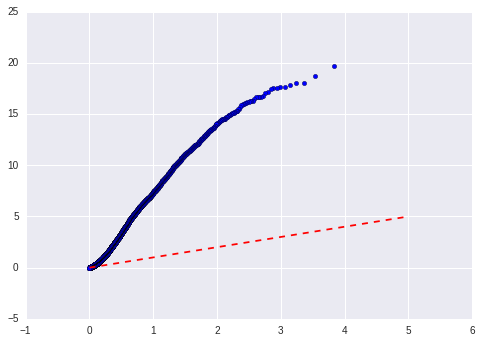

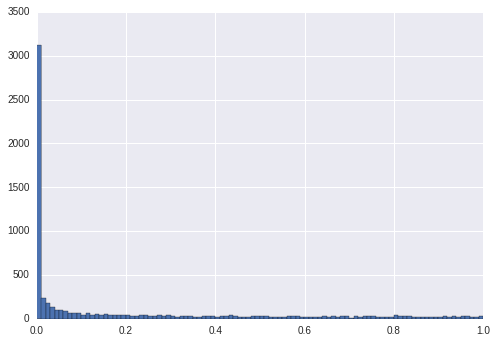

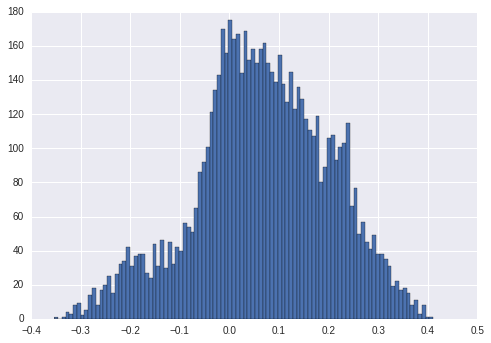

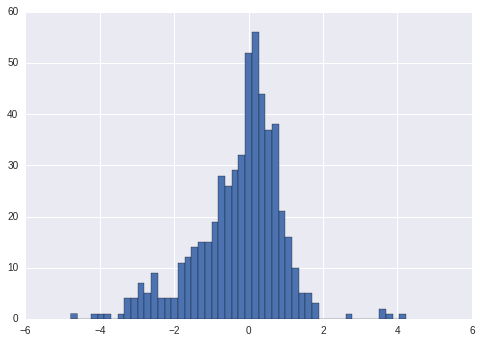

In [1772]:
temp_df = concat((diamond_kos, ppmet.loc[:,38637].reset_index('GROUP', drop=True)), axis=1).dropna(axis=0)
temp_corr = [spearmanr(temp_df.iloc[:,temp_df.shape[1]-1], temp_df.iloc[:,i]) for i in range(temp_df.shape[1]-1)]
# temp_corr = temp_df.T.corr('spearman')

temp_pvals = np.array([p[1] for p in temp_corr if p[1] != np.nan])
temp_corrs = np.array([p[0] for p in temp_corr if p[0] != np.nan])

temp_pvals = temp_pvals[~np.isnan(temp_pvals)]
temp_corrs = temp_corrs[~np.isnan(temp_corrs)]

# len(temp_pvals)
temp_pvals.sort()
temp_corrs.sort()

print temp_corrs[:20]
print temp_corrs[-20:]
print temp_pvals[:20]
# print temp_pvals[-20:]

plt.scatter(-np.log10(np.array(range(1,1+len(temp_pvals)))/float(len(temp_pvals))),-np.log10(temp_pvals))
plt.plot([0, 5], [0, 5], '--', color='red')
plt.show()

plt.hist(temp_pvals, bins=100)
# plt.xlim((0,0.01))
plt.show()
plt.hist(temp_corrs, bins=100)
plt.show()


plt.hist(ppmet.loc[:,15749].dropna(), bins=50)
plt.show()
# np.isnan(temp_pvals).sum()

##### q-q plot

In [525]:
plt.clf()
xs =np.log10(np.array(range(1,1+mental_per_met_f.shape[0]))/float(mental_per_met_f.shape[0]))
pvals = np.log10(mental_per_met_f.sort_values(['empirical_p_val']).empirical_p_val)
plt.subplot(1, 2, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - Mantel test P-values')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')
plt.subplot(1, 2, 2)
plt.scatter(-xs[0:50], -pvals[0:50])
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - first 50 values')
xmin = min(min(-xs[0:50]), min(-pvals[0:50]))
plt.plot([xmin, xmax], [xmin, xmax], '--', color='red')
plt.savefig('Grouping_by_ko_5_100000_0.5/Mantel/Q-Q_plot.png', bbox_inches='tight')

mental_per_met_shuffle = pd.DataFrame(columns=['COMP_ID', 'dist_matrix_size', 'cor_method', 'num_permutations', 'tail','correlation', 'empirical_p_val', 'z_score', 'EMGenes_file', 'EMGenes_distance'])
num_permutations = 100

EMGenes_BinEuc_res_shuffled = EMGenes_BinEuc_res.copy()
perm_order = np.random.permutation(EMGenes_BinEuc_res_shuffled.index)
EMGenes_BinEuc_res_shuffled.index = perm_order
EMGenes_BinEuc_res_shuffled.columns = perm_order
metabs_remain = dist_mat_by_metabolite_not_null.keys()
while len(metabs_remain) > 0:
    print num_permutations
    print len(metabs_remain)
    c = 0
    for m in metabs_remain:
        print c; c+=1
        pos = dist_mat_by_metabolite_not_null[m][1]
        temp_EM = EMGenes_BinEuc_res_shuffled.loc[pos, pos]
        r, p, z = mantel_test(dist_mat_by_metabolite_not_null[m][0], temp_EM.values, num_permutations, method=cor_method, tail=tail)
        mental_per_met_shuffle.loc[mental_per_met_shuffle.shape[0]]  = [m, len(pos), cor_method, num_permutations, tail, r, p, z, EMGenes_file, EMGenes_distance]
    metabs_remain = mental_per_met_shuffle[mental_per_met_shuffle.empirical_p_val <= 5./num_permutations].COMP_ID
    for m in metabs_remain:
        mental_per_met_shuffle = mental_per_met_shuffle[mental_per_met_shuffle.COMP_ID != m]
    mental_per_met_shuffle.index = range(mental_per_met_shuffle.shape[0])
    num_permutations *= 10

plt.clf()
xs =np.log10(np.array(range(1,1+mental_per_met_f.shape[0]))/float(mental_per_met_f.shape[0]))
pvals = np.log10(mental_per_met_f.sort_values(['empirical_p_val']).empirical_p_val)
plt.subplot(1, 2, 1)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - Mantel test P-values')
xmax = min(max(-xs), max(-pvals))
ylim = [min(-pvals)-1, max(-pvals)+1]
plt.plot([0, xmax], [0, xmax], '--', color='red')
plt.ylim(ylim)
plt.subplot(1, 2, 2)
xs =np.log10(np.array(range(1,1+mental_per_met_shuffle.shape[0]))/float(mental_per_met_shuffle.shape[0]))
pvals = np.log10(mental_per_met_shuffle.sort_values(['empirical_p_val']).empirical_p_val)
plt.scatter(-xs, -pvals)
plt.ylabel('P-value [-log10]')
plt.xlabel('P-values under null hypothesis [-log10]')
plt.title('Q-Q plot - Mantel test P-values (Shuffled)')
xmax = min(max(-xs), max(-pvals))
plt.plot([0, xmax], [0, xmax], '--', color='red')
plt.ylim(ylim)
plt.savefig('Grouping_by_ko_5_100000_0.5/Mantel/Q-Q_plot_real_vs_shuffle.png', bbox_inches='tight')
plt.clf()

In [36]:
s = Utils.Load('Grouping_by_ko_5_100000_0.5/Grouped_analysis/GSEA_2_11')
q = fdr_correction(s.test_pval)[1]
q
s['qval'] = q
s.sort_values('test_pval')

,CompID,KEGGID,KEGG_db_type,KEGG_db_ID,n_genes_in_kegg,n_genes_in_test,n_genes_rest,test_pval,test_statistic,stat_test,downstream_cols,GSEA_ID,qval
57,22130,C05607,ko,ko:K02614,680,12,171895,0.001792,-530676.5,directed_mannwhitneyu,bac_genes,pvals.csv,0.161257
73,1471,C00121,ko,ko:K10108,698,51,171856,0.007053,-3512573.5,directed_mannwhitneyu,bac_genes,pvals.csv,0.254369
13,43424,C11142,ko,ko:K02046,166,26,171881,0.008479,1630333.0,directed_mannwhitneyu,bac_genes,pvals.csv,0.254369
0,32425,C04555,ko,ko:K01130,1032,28,171879,0.014367,-1832028.0,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
28,18349,C02043,ko,ko:K01667,354,24,171883,0.019651,1561568.0,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
45,37253,C02630,ko,ko:K01028,1546,31,171876,0.025101,-2123061.5,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
58,22130,C05607,ko,ko:K13607,372,5,171902,0.029061,219502.5,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
80,1471,C00121,ko,ko:K03412,246,22,171885,0.032646,-1461719.5,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
10,32504,C16513,ko,ko:K10805,64,6,171901,0.034317,294373.0,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036
71,1471,C00121,ko,ko:K01839,1335,67,171840,0.035840,-5025155.0,directed_mannwhitneyu,bac_genes,pvals.csv,0.264036


In [1238]:
pvals = read_csv('Grouping_by_ko_5_100000_0.5/Grouped_analysis/pvals.csv')
pvals = pvals.set_index('Unnamed: 0')
corrs = read_csv('Grouping_by_ko_5_100000_0.5/Grouped_analysis/corrs.csv')
corrs = corrs.set_index('Unnamed: 0')

In [1215]:
metabs.loc[relevant_compounds]

,PATHWAY_SORTORDER,BIOCHEMICAL,SUPER_PATHWAY,SUB_PATHWAY,PLATFORM,CHEMICAL_ID,RI,MASS,CAS,PUBCHEM,CHEMSPIDER,KEGG,Group HMDB_ID
COMP_ID,,,,,,,,,,,,,
22116,247,4-methyl-2-oxopentanoate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",LC/MS Neg,100000551,2170,129.056,816-66-0,70,69,C00233,HMDB00695
22132,250,alpha-hydroxyisocaproate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",LC/MS Neg,100000706,1840,131.071,10303-64-7,83697,75520,C03264,HMDB00746
46487,NaN,X - 21442,NaN,NaN,LC/MS Neg,NaN,3823,333.208,NaN,NaN,NaN,NaN,NaN
46507,NaN,X - 11850,NaN,NaN,LC/MS Neg,NaN,3176,226.018,NaN,NaN,NaN,NaN,NaN
44526,301,3-methyl-2-oxobutyrate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",LC/MS Neg,100000936,1465,115.04,3715-29-5,49,48,C00141,HMDB00019
39730,1572,N-stearoyltaurine,Lipid,Endocannabinoid,LC/MS Neg,100003240,5782,390.268,63155-80-6,168274,147194,NaN,NaN
18362,1268,azelate (nonanedioate),Lipid,"Fatty Acid, Dicarboxylate",LC/MS Neg,2029,1276,187.098,123-99-9,2266,2179,C08261,HMDB00784
42087,233,indoleacetylglutamine,Amino Acid,Tryptophan Metabolism,LC/MS Neg,100001731,2535,302.115,NaN,25200879,NaN,NaN,HMDB13240
542,1401,3-hydroxybutyrate (BHBA),Lipid,Ketone Bodies,LC/MS Polar,254,1444,103.04,625-72-9,441,428,C01089,HMDB00357


In [1225]:
relevant_compounds = list(mantel_per_metabolite[mantel_per_metabolite['q_value'] < 0.1]['COMP_ID'])
relevant_compounds = [str(c) for c in relevant_compounds]
relevant_pvals = pvals.loc[:,relevant_compounds].dropna(how='all', axis=1)
relevant_pvals.columns

Index([u'22116', u'22132', u'44526', u'18362', u'542', u'1868'], dtype='object')

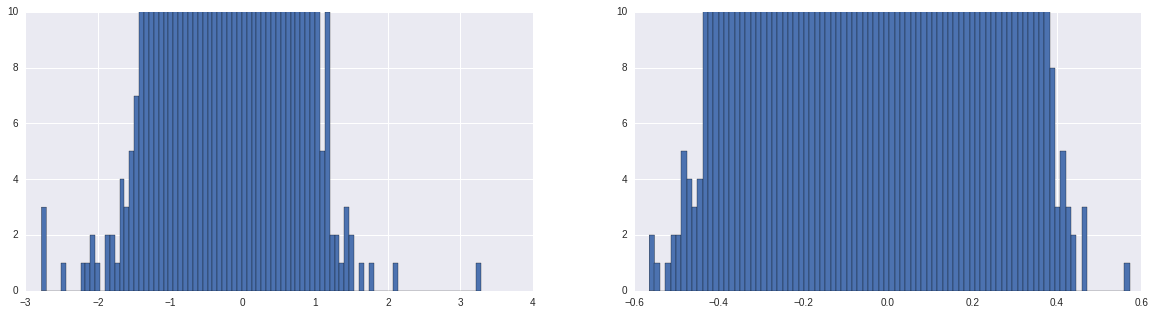

-0.0113168131012
-0.0127130893065


In [1307]:
comp = 44526
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(relevant_pvals.loc[:,str(comp)], bins=90)
plt.ylim((0,10))
# plt.show()
plt.subplot(1,2,2)
plt.hist(corrs.loc[:,str(comp)], bins=90)
plt.ylim((0,10))
plt.show()
print corrs.loc[:,str(comp)].mean()
print relevant_pvals.loc[:,str(comp)].mean()

In [1308]:
relevant_pvals.loc[:,str(comp)].loc[relevant_pvals.loc[:,str(comp)] > 3]

Unnamed: 0
MH0025_GL0034663    3.288415
Name: 44526, dtype: float64

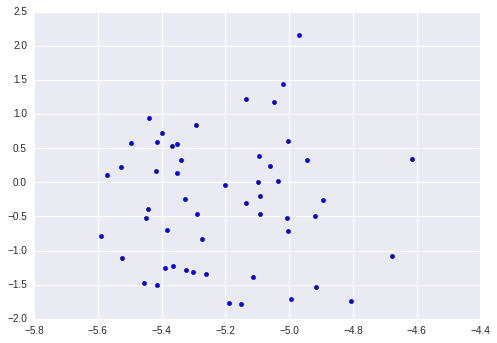

In [1309]:
plt.scatter(EMGenes_mat['NLM008_GL0043731'] , met_gr_rel.loc[:,comp])
plt.show()

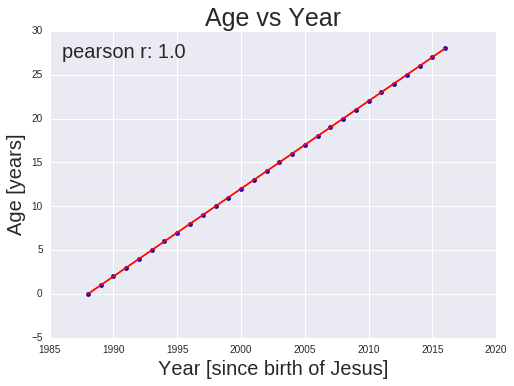

In [1906]:
plt.scatter(range(1988,2017), range(29))
plt.title("Age vs Year", fontsize=25)
plt.xlabel('Year [since birth of Jesus]', fontsize=20)
plt.ylabel('Age [years]',  fontsize=20)
slope, intercept = np.polyfit(range(1988,2017), range(29), 1)
abline_values = [slope * i + intercept for i in range(1988,2017)]
plt.plot(range(1988,2017), abline_values, 'r')
plt.text(1986, 27, 'pearson r: 1.0', fontsize=20)
plt.savefig('/home/noamba/Pictures/Liron_age_vs_year.png')
plt.show()